# HOTEL PREDICTION
##  ver 4.0  author Yunshan Wang(1721621@student.vu.nl)  @Create 25-04-2022
### ver1.0    
完成了分段读取程序,EDA,竞争者信息特征生成,酒店点击率预订率特征生成    
### ver2.0 
1.重构了竞争者信息特征生成，解决竞争者信息特征生成时间较长  
2.重构了数据读取,特征生成,完成了Lightgdm训练预测  
3.执行方式：(不论何种何种执行方式,限制性库引入,readcsvfile和reduce_dataset_memory  
a.从开始顺序执行,读取数据按字典读取,不用再执行1.2的缩减内存主程序,3.2步骤时间较长6-10小时左右.  
b.如已生成3.2的竞争酒店统计数据compcount(直接拷贝程序目录),可从开始执行到3.1后,直接执行3.2.b2,读取分段的数据,继续后续步骤.  
c.如已保存特征数据hotelfeatdataset(直接拷贝程序目录),可直接从6开始读取特征数据,再处理特征或增减新特征,进行新模型训练.   
### ver 3.0
增加了xgboost训练和预测,label和labelall两种标签进行训练均正常,label得分0.52,labelall得分0.88
### ver 4.0
1.经kaggle验证：使用xgboost评估指标label,使用rank:parewise评估指标最高, 因此选择rank:parewise   
2.增加了xgboost两种特种重要性指标，选择23个特征kaggle得分有所下降
3.增加shap特征重要性分析，选择12个特征kaggle得分有所有下降,但高于23个特征的xgboost的特征重要性选择         

### 存在问题:   
#### 1. 模型训练问题
测试集中无booking_bool,click_bool,position,gross_bookings_usd数据,因此在模型训练中设置了label(int8),lableall(int16),   
label   = booking_bool*5+click_bool   
labelall = (booking_bool*5+click_bool)*1000+int(log(gross_bookings_usd))*100+position   
用label作为标签lightgbm训练,因未加入position,gross_bookings_usd,因此得分较低,0.5左右   
用labelall作为标签lightgbm训练出现错误：Label 34 is not less than the number of label mappings (31),目前未找到原因  
在6.2中修改label=['labelall']就可以选择不同的label   
#### 2. 竞争者信息特征生成时间较长
竞争者信息特征的生成依然生成时间长,目前采用分段存储,并存储特征文件的方式,后期训练时直接读取存储的特征文件.

In [2]:
"""
@author Group 17-Yunshan Wang(1721621@student.vu.nl 1721621)
@Create 25-04-2022
"""
#-*- coding:utf-8 -*-
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

%matplotlib inline

## 1. 数据读取
### 1.1. 数据读取
读取训练数据和测试数据并合并   
数据文件较大,读取时间较长,为了减少读取时间,通过chunk分块读取再合并,为了减少内存占用,根据数据的类型和最大值,通过data_types设置适合属性的数据类型

In [3]:
def readcsvfile(csvfilename,data_types={}):
    '''
    读取csv文件，返回dataframe
    
    Args:
        csvfilename: 含路径的csv文件名
        data_types：数据项类型字典,缺省为空
    Returns:
        读取的dataframe
    '''
    if os.path.exists(csvfilename):
        ## chunk分块读取csv大文件
        chunks = pd.read_csv(csvfilename, encoding='utf-8', dtype =data_types, iterator=True, chunksize=100000)
        chunk_list = list()
        for chunk in chunks:
            chunk_list.append(chunk)
        tmp = pd.concat(chunk_list, axis=0, ignore_index=False)
        return tmp
    else:
        print('Error:The file {} does not exist!'.format(csvfilename))

In [43]:
data_types_dict = {
    'srch_id':'int32', 'site_id':'int8', 'visitor_location_country_id':'int16',
    'visitor_hist_starrating':'float16', 'visitor_hist_adr_usd':'float16', 'prop_country_id':'int16',
    'prop_id':'int32', 'prop_starrating':'int8', 'prop_review_score':'float16', 
    'prop_brand_bool':'bool','prop_location_score1':'float16', 'prop_location_score2':'float16', 
    'prop_log_historical_price':'float16', 'position':'int8', 'price_usd':'float32', 
    'promotion_flag':'bool',  'srch_destination_id':'int16', 'srch_length_of_stay':'int8', 
    'srch_booking_window':'int16', 'srch_adults_count': 'int8', 'srch_children_count': 'int8', 
    'srch_room_count': 'int8', 'srch_saturday_night_bool': 'bool', 'srch_query_affinity_score': 'float16', 
    'orig_destination_distance': 'float16', 'random_bool': 'bool', 
    'comp1_rate': 'Int8', 'comp1_inv': 'Int8','comp1_rate_percent_diff': 'float32', 
    'comp2_rate': 'Int8', 'comp2_inv': 'Int8','comp2_rate_percent_diff': 'float32', 
    'comp3_rate': 'Int8', 'comp3_inv': 'Int8','comp3_rate_percent_diff': 'float32', 
    'comp4_rate': 'Int8', 'comp4_inv': 'Int8','comp4_rate_percent_diff': 'float32', 
    'comp5_rate': 'Int8', 'comp5_inv': 'Int8','comp5_rate_percent_diff': 'float32', 
    'comp6_rate': 'Int8', 'comp6_inv': 'Int8','comp6_rate_percent_diff': 'float32', 
    'comp7_rate': 'Int8', 'comp7_inv': 'Int8','comp7_rate_percent_diff': 'float32', 
    'comp8_rate': 'Int8', 'comp8_inv': 'Int8','comp8_rate_percent_diff': 'float32', 
    'click_bool': 'bool', 'gross_bookings_usd': 'float32','booking_bool': 'bool',
    'position': 'Int8'}
path = os.getcwd()+'\\'
trainfilename = 'training_set_VU_DM.csv'
testfilename = 'test_set_VU_DM.csv'
t0 = datetime.datetime.now()
print("开始读取训练数据和预测数据...")
# 按data_types_dict指定类型读取，减少内存使用，该方式是通过自动读取后观察数据后设置合适的数据类型，
# 设置合理的数据类型，与reduce_dataset_memeory函数相比使用更少的内存，并充分保留了NaN值
train=readcsvfile(path + trainfilename, data_types_dict) 
test=readcsvfile(path + testfilename, data_types_dict) 
# 按pandas自动识别类型读取，占用内存大，可通过后面的reduce_dataset_memeory函数减少内存
#train=readcsvfile(path + trainfilename) 
#test=readcsvfile(path + testfilename) 
print('读取训练数据和预测数据一共用时{}秒'.format(datetime.datetime.now() - t0))
# 软件调试时使用，选择1%的数据，减少运行时间
#train = train.sample(frac=0.01, random_state=99)
#test = test.sample(frac=0.01, random_state=99)
train['data_type'] = 1
test['data_type'] = 0
t0 = datetime.datetime.now()
print("开始合并训练数据和预测数据...")
data = pd.concat([train, test], ignore_index=True, sort=False)
print('合并数据一共用时{}秒'.format(datetime.datetime.now() - t0))

开始读取训练数据和预测数据...
读取训练数据和预测数据一共用时0:01:09.668860秒
开始合并训练数据和预测数据...
合并数据一共用时0:00:00.970576秒


### 1.2. 内存优化
根据硬件情况选择执行，如果使用pandas默认的自动识别数据类型的读取，可运行该步骤减少dataframe内存占用

In [4]:
def reduce_dataset_memory(df):     
    '''
    iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    
    Args:
        df: dataframe

    Returns:
         reduce memory of dataframe
    '''
    start_mem = df.memory_usage().sum() / 1024 **  2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != bool and col_type != object :
            c_min = df[col].min()
            
            c_max = df[col].max()
            if str(col_type)[:3] == 'int' or str(col_type)[:3] =='Int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    if df[col].isnull().any():
                        df[col] = df[col].astype('Int8')
                    else:
                        df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    if df[col].isnull().any():
                        df[col] = df[col].astype('Int16')
                    else:
                        df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    if df[col].isnull().any():
                        df[col] = df[col].astype('Int32')
                    else:
                        df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    if df[col].isnull().any():
                        df[col] = df[col].astype('Int64')
                    else:
                        df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == 'float' or str(col_type)[:5] == 'Float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

### 如已采用按字典定义读取，本步骤可不执行

In [ ]:
t0 = datetime.datetime.now()
print("开始优化内存...")
data=reduce_dataset_memory(data)
print('优化内存一共用时{}秒'.format(datetime.datetime.now() - t0))

## 2. First EDA
为构造特征工程以及模型建立做准备   
### 2.1. 预览数据
#### 数据类型及空值

In [38]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4958347 entries, 0 to 4958346
Data columns (total 55 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   srch_id                      4958347 non-null  int32         
 1   date_time                    4958347 non-null  datetime64[ns]
 2   site_id                      4958347 non-null  int8          
 3   visitor_location_country_id  4958347 non-null  int16         
 4   visitor_hist_starrating      251866 non-null   float16       
 5   visitor_hist_adr_usd         252988 non-null   float16       
 6   prop_country_id              4958347 non-null  int16         
 7   prop_id                      4958347 non-null  int32         
 8   prop_starrating              4958347 non-null  int8          
 9   prop_review_score            4950983 non-null  float16       
 10  prop_brand_bool              4958347 non-null  bool          
 11  prop_locati

array([[<AxesSubplot:title={'center':'srch_id'}>,
        <AxesSubplot:title={'center':'site_id'}>,
        <AxesSubplot:title={'center':'visitor_location_country_id'}>,
        <AxesSubplot:title={'center':'visitor_hist_starrating'}>,
        <AxesSubplot:title={'center':'visitor_hist_adr_usd'}>,
        <AxesSubplot:title={'center':'prop_country_id'}>,
        <AxesSubplot:title={'center':'prop_id'}>],
       [<AxesSubplot:title={'center':'prop_starrating'}>,
        <AxesSubplot:title={'center':'prop_review_score'}>,
        <AxesSubplot:title={'center':'prop_log_historical_price'}>,
        <AxesSubplot:title={'center':'position'}>,
        <AxesSubplot:title={'center':'price_usd'}>,
        <AxesSubplot:title={'center':'srch_destination_id'}>,
        <AxesSubplot:title={'center':'srch_length_of_stay'}>],
       [<AxesSubplot:title={'center':'srch_booking_window'}>,
        <AxesSubplot:title={'center':'srch_adults_count'}>,
        <AxesSubplot:title={'center':'srch_children_coun

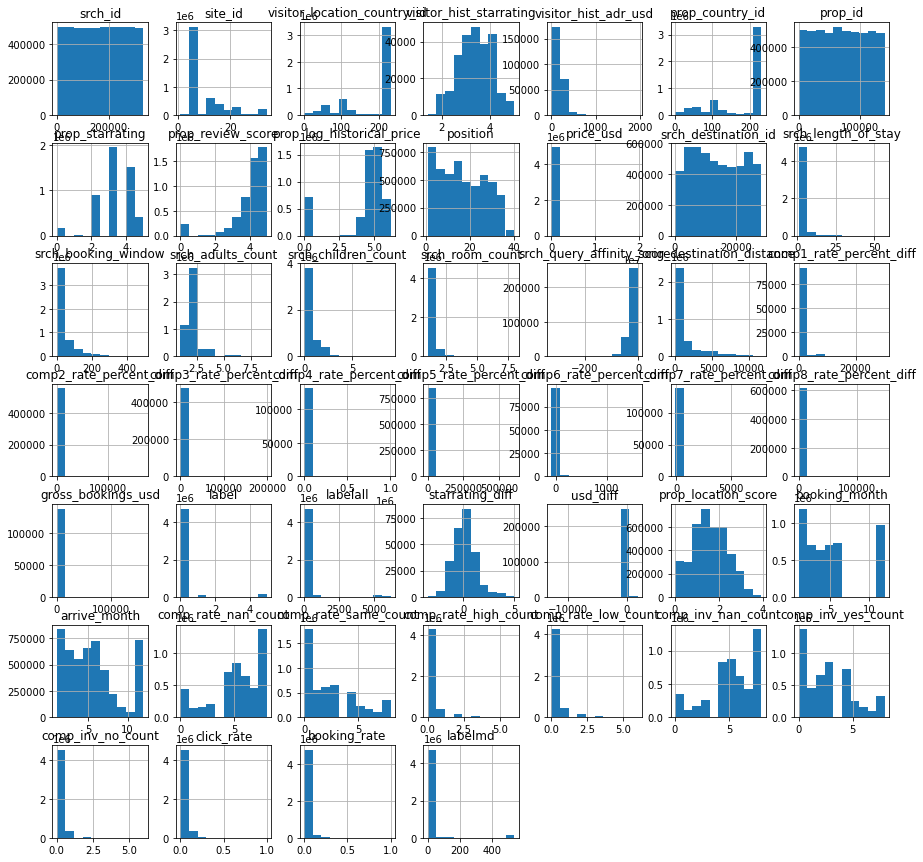

In [23]:
train.hist(figsize=(15,15))

<BarContainer object of 6 artists>

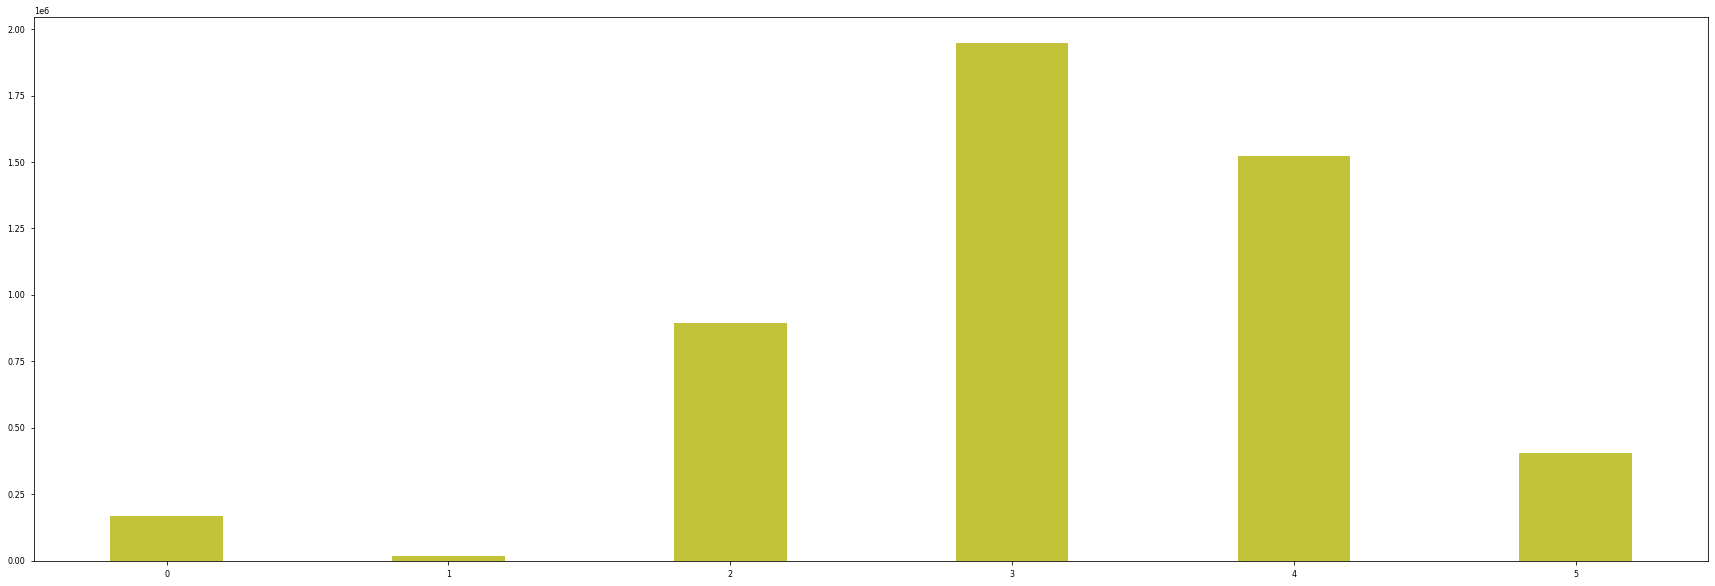

In [81]:
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')
fig = plt.figure(figsize=(30,10))
num=8
countcol={'booking_bool':'count'}
compcol='prop_starrating'
plotdata=data.groupby(compcol).agg(countcol)
plt.bar(plotdata.index, plotdata.iloc[:,0], width=0.4,color=palette(2*i), alpha=0.9, label=compcol)

#### 预定酒店与竞争酒店价格对比柱状图
预定酒店与8家竞争酒店价格相比，预定酒店价格价格相同得比例较高，其中价格低比价格高的预定数量多，说明价格是查询者预定考虑的重要因素

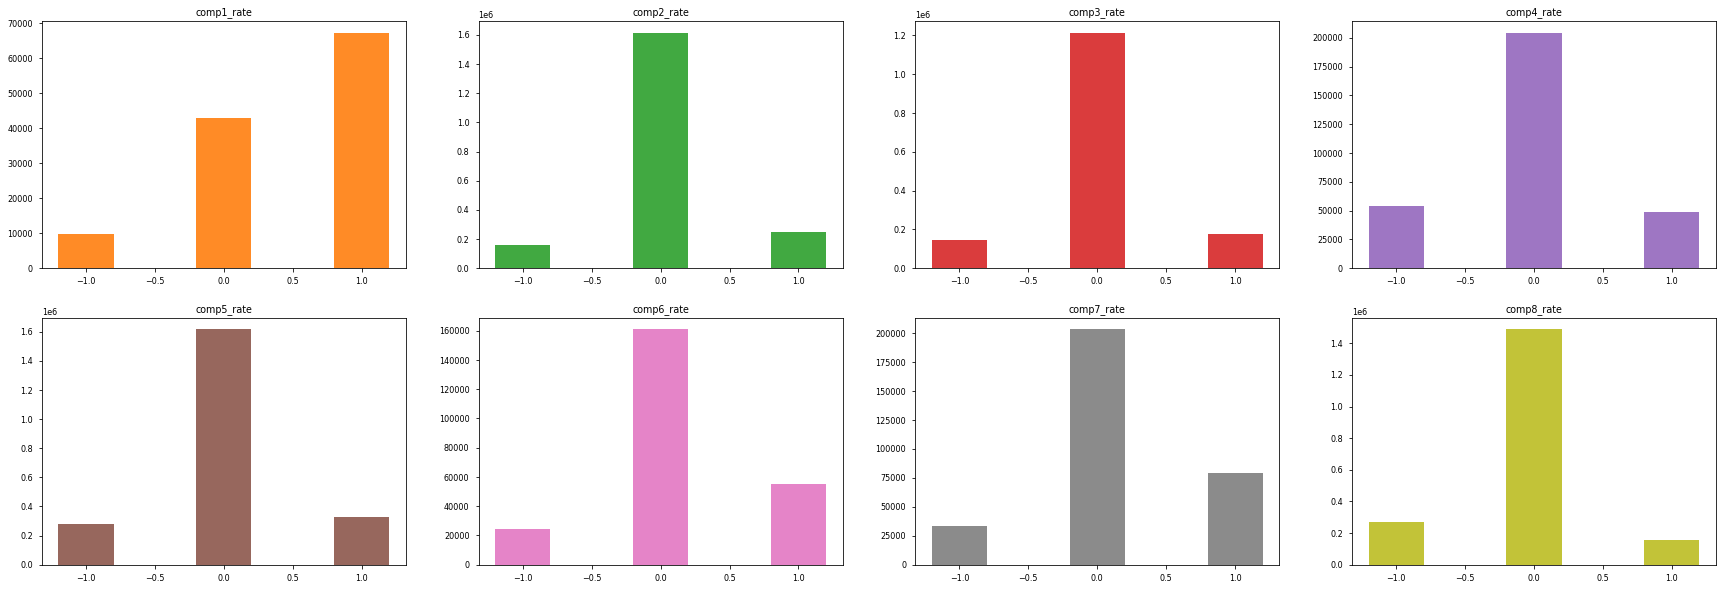

In [76]:
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')
fig = plt.figure(figsize=(30,10))
num=8
countcol={'booking_bool':'count'}
for i in range(1,num+1):
    compcol='comp{}_rate'.format(i)
    ax = fig.add_subplot(int(num/4),4, i)
    ax.set_title(compcol)
    plotdata=data.groupby(compcol).agg(countcol)
    ax.bar(plotdata.index, plotdata.iloc[:,0], width=0.4,color=palette(2*i), alpha=0.9, label=compcol)

#### 浏览的酒店与竞争酒店是否有房对比柱状图
通过浏览的酒店与8家竞争酒店是否有房情况对比，可以看出大多数情况下竞争酒店无房的情况下，酒店被预定的成功率会提高

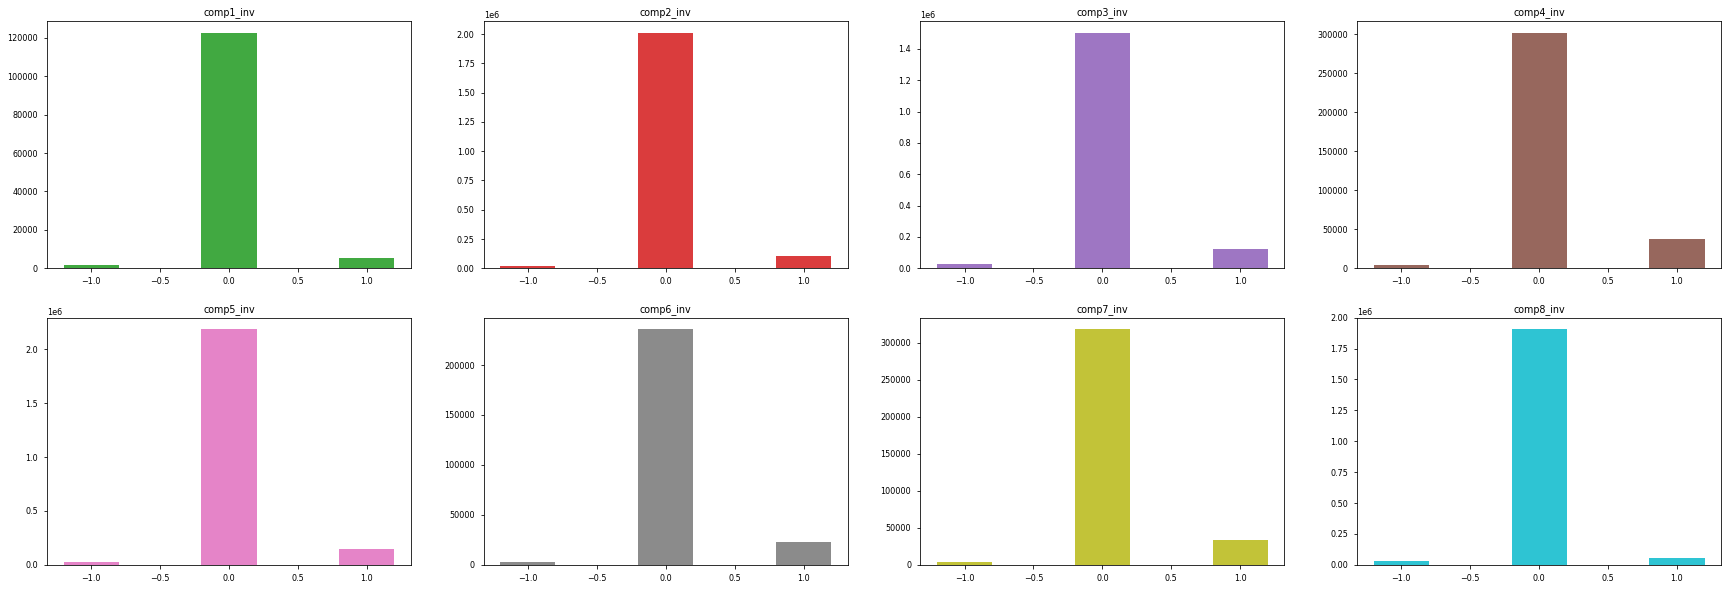

In [79]:
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')
fig = plt.figure(figsize=(30,10))
num=8
countcol={'click_bool':'count'}
for i in range(1,num+1):
    compcol='comp{}_inv'.format(i)
    ax = fig.add_subplot(int(num/4),4, i)
    ax.set_title(compcol)
    plotdata=data.groupby(compcol).agg(countcol)
    ax.bar(plotdata.index, plotdata.iloc[:,0], width=0.4,color=palette(2*i+2), alpha=0.9, label=compcol)

#### 2.2. 数据描述
查看数据分布情况   

In [89]:
data.describe()

srch_id       site_id  visitor_location_country_id  \
count  9.917530e+06  9.917530e+06                 9.917530e+06   
mean   1.665063e+05  9.966175e+00                 1.752954e+02   
std    9.613117e+04  7.657325e+00                 6.590955e+01   
min    1.000000e+00  1.000000e+00                 1.000000e+00   
25%    8.311500e+04  5.000000e+00                 1.000000e+02   
50%    1.667860e+05  5.000000e+00                 2.190000e+02   
75%    2.498550e+05  1.400000e+01                 2.190000e+02   
max    3.327870e+05  3.400000e+01                 2.310000e+02   

       visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  \
count            505297.000000           507612.0000     9.917530e+06   
mean                       NaN                   NaN     1.739055e+02   
std                   0.000000                   NaN     6.834768e+01   
min                   1.000000                0.0000     1.000000e+00   
25%                   2.919922              110.3125     1.000000e+02   
50%                   3.439453              151.8750     2.190000e+02   
75%                   3.939453              214.3750     2.190000e+02   
max                   5.000000             2768.0000     2.300000e+02   

            prop_id  prop_starrating  prop_review_score  prop_location_score1  \
count  9.917530e+06     9.917530e+06          9902900.0          9.917530e+06   
mean   7.008015e+04     3.181534e+00                NaN                   NaN   
std    4.061177e+04     1.050191e+00                0.0          0.000000e+00   
min    1.000000e+00     0.000000e+00                0.0          0.000000e+00   
25%    3.501000e+04     3.000000e+00                3.5          1.790039e+00   
50%    6.961500e+04     3.000000e+00                4.0          2.769531e+00   
75%    1.051770e+05     4.000000e+00                4.5          4.039062e+00   
max    1.408210e+05     5.000000e+00                5.0          6.980469e+00   

       ...      comp6_inv  comp6_rate_percent_diff     comp7_rate  \
count  ...  524145.000000             1.933120e+05  631077.000000   
mean   ...       0.075651             2.301390e+01       0.147061   
std    ...       0.302058             2.560394e+03       0.578748   
min    ...      -1.000000             2.000000e+00      -1.000000   
25%    ...       0.000000             6.000000e+00       0.000000   
50%    ...       0.000000             1.100000e+01       0.000000   
75%    ...       0.000000             1.800000e+01       1.000000   
max    ...       1.000000             1.125686e+06       1.000000   

           comp7_inv  comp7_rate_percent_diff    comp8_rate     comp8_inv  \
count  713175.000000            277838.000000  3.819043e+06  3.960388e+06   
mean        0.082259                20.141888 -6.072490e-02  9.889435e-03   
std         0.316165               136.192963  4.692456e-01  2.031648e-01   
min        -1.000000                 2.000000 -1.000000e+00 -1.000000e+00   
25%         0.000000                 7.000000  0.000000e+00  0.000000e+00   
50%         0.000000                12.000000  0.000000e+00  0.000000e+00   
75%         0.000000                20.000000  0.000000e+00  0.000000e+00   
max         1.000000             30216.000000  1.000000e+00  1.000000e+00   

       comp8_rate_percent_diff  gross_bookings_usd     data_type  
count             1.225707e+06       138390.000000  9.917530e+06  
mean              2.320823e+01          386.279633  4.999579e-01  
std               9.460939e+02          821.172607  5.000000e-01  
min               2.000000e+00            0.000000  0.000000e+00  
25%               7.000000e+00          124.000000  0.000000e+00  
50%               1.100000e+01          218.399994  0.000000e+00  
75%               1.700000e+01          429.790009  1.000000e+00  
max               1.494000e+05       159292.375000  1.000000e+00  

[8 rows x 48 columns]

#### 2.3. 相关性分析
从相关热力图中可以看出comp1_rate...comp8_rate有较强的相关性， comp1_inv...comp8_inv有较强的相关性   

<AxesSubplot:>

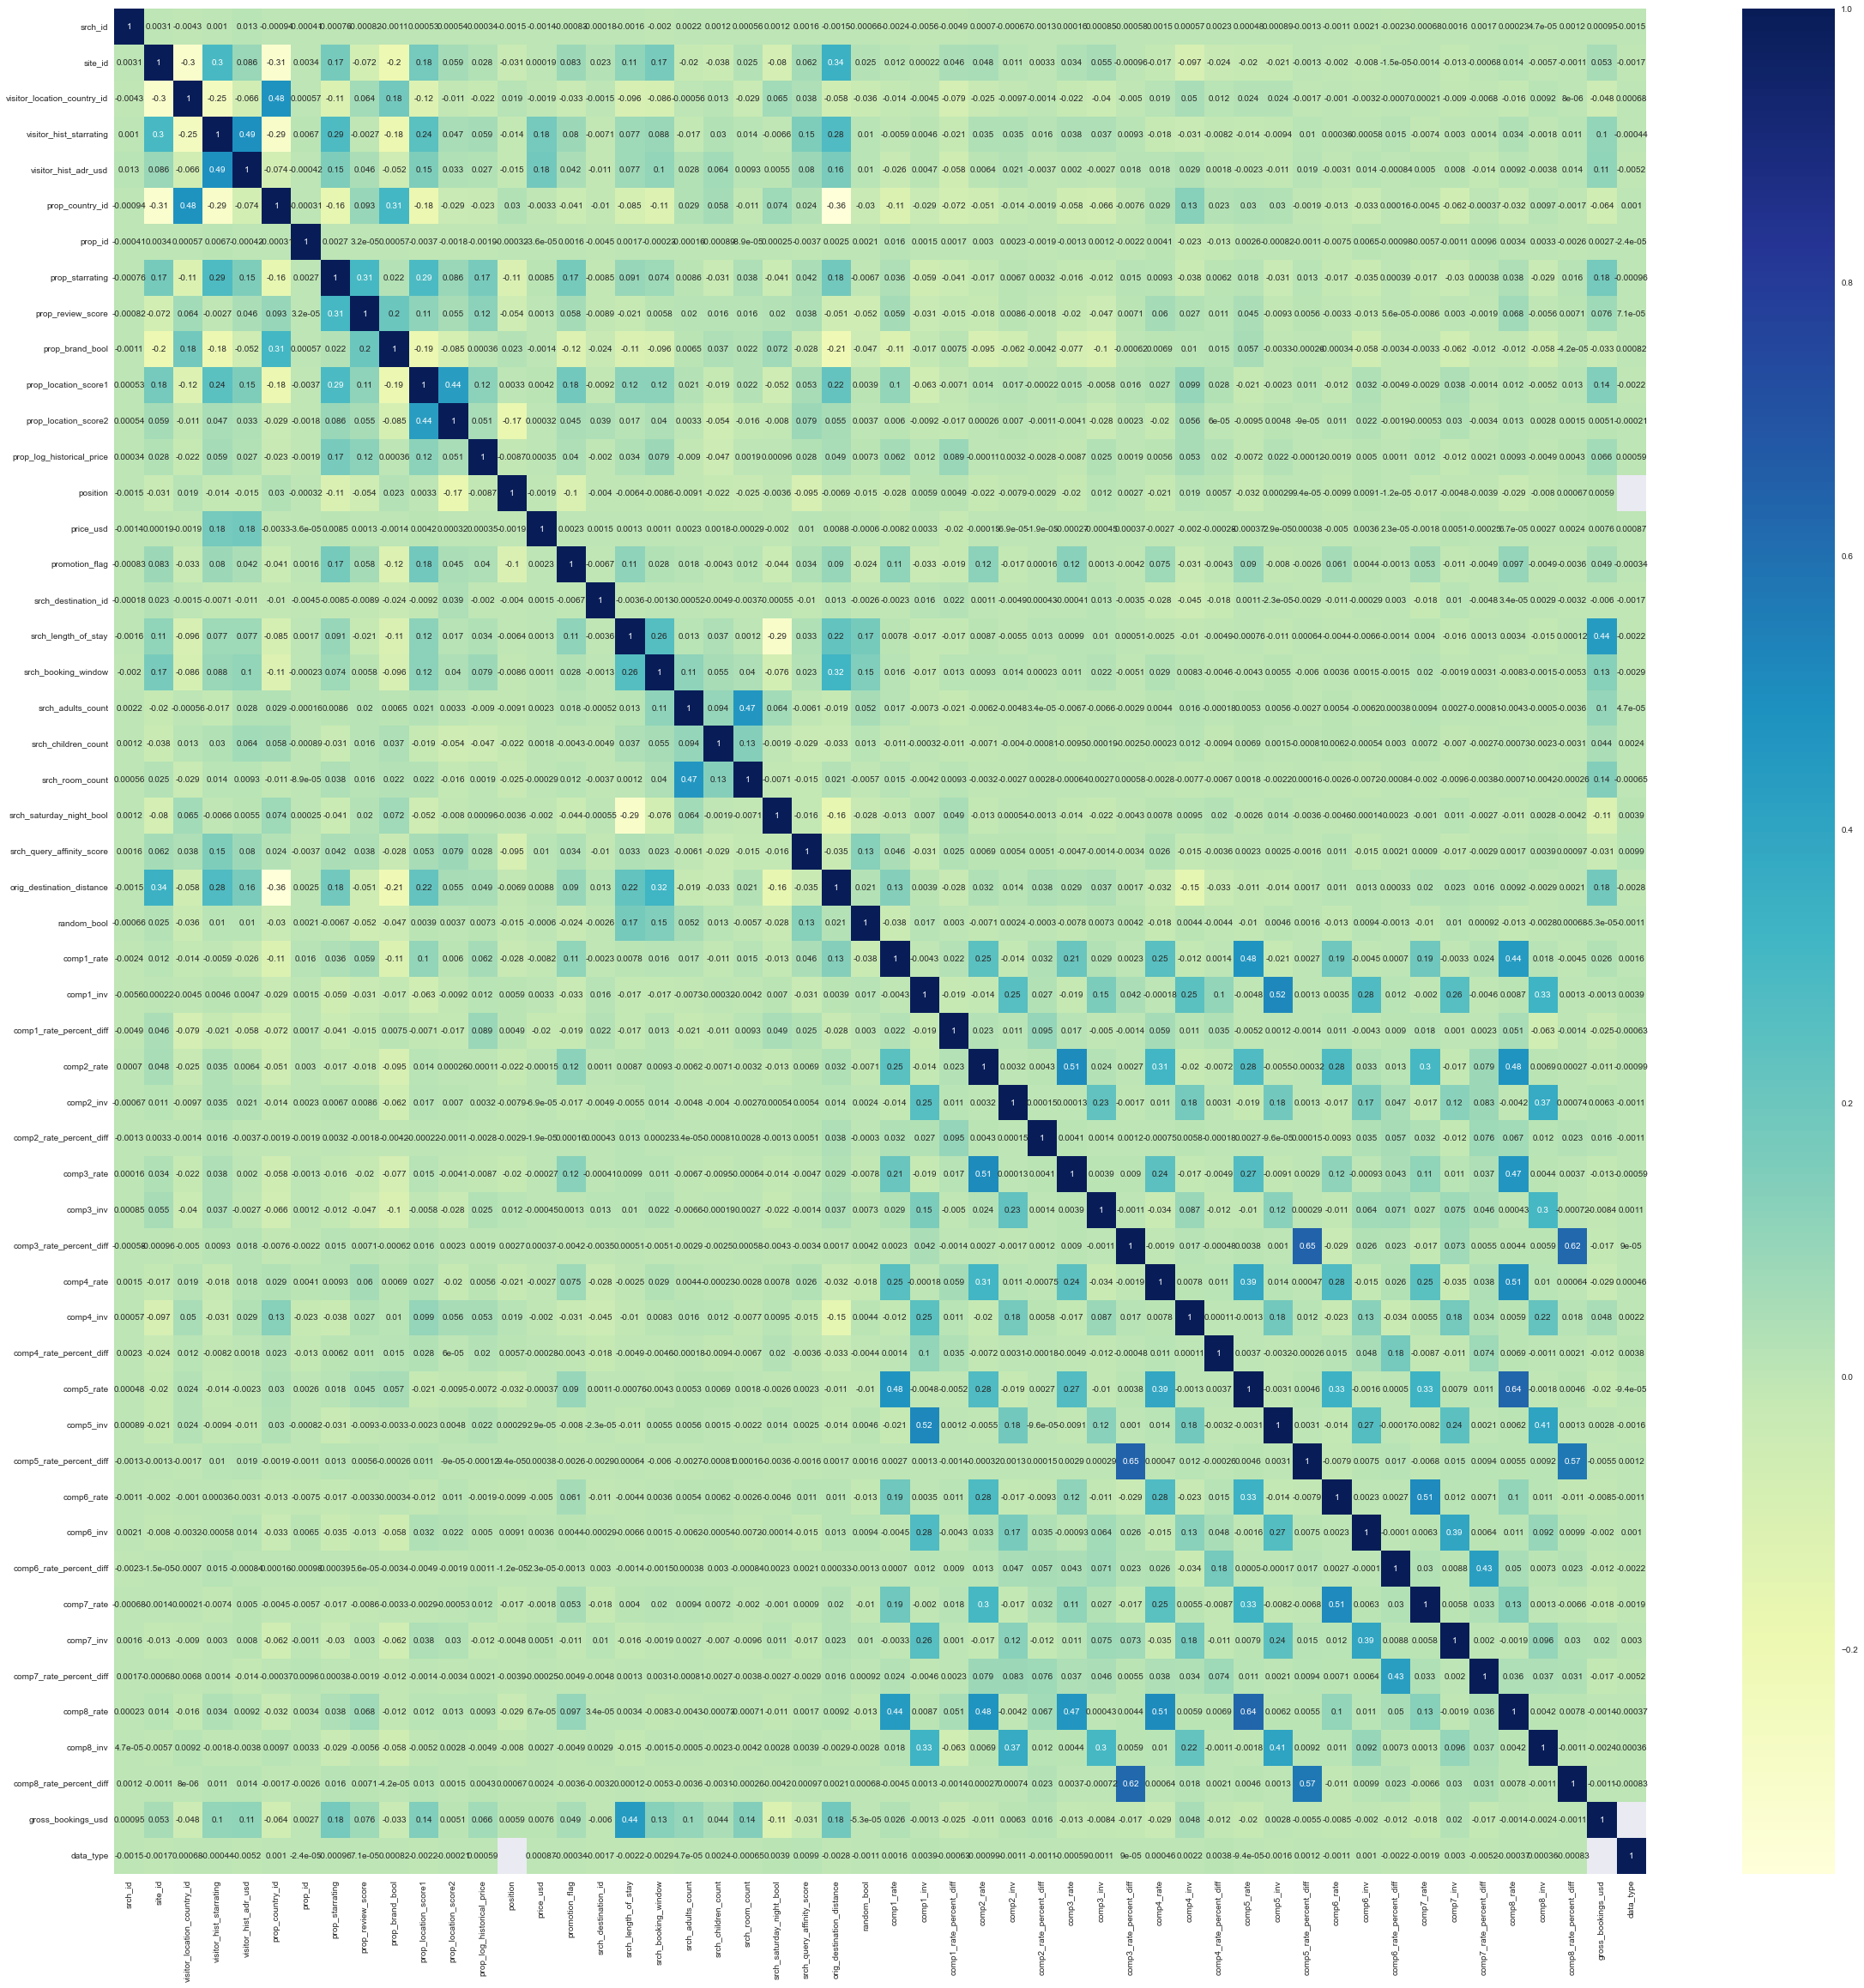

In [90]:
# 绘制相关性
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")

### 3. Feature Engine

#### 3.1. Data Prepration
1.转换date_time为dataetime  
2.转换click_bool,booking_bool,data_type,data_type为bool   
3.转换comp_rate,comp_inv为Int8(含空值）  

In [44]:
def dataprepration(df):
    # 将date_time列转换时间序列，object->datetime64[ns]
    tmp=df.copy()
    tmp['date_time']=pd.to_datetime(tmp['date_time'])
    
    boolcols=['click_bool','booking_bool','data_type']
    for col in boolcols:
        if col in tmp.columns:
            tmp.loc[:,col] = tmp.loc[:,col].apply(lambda x:False if (x is np.nan) else x).astype('bool') 

    for i in range(1,9):
        # 如果comp1_rate...comp8_rate为float，转换为Int8(可包含NaN)
        compcol='comp{}_rate'.format(i)
        if compcol in tmp.columns:
            if str(tmp[compcol].dtype)[:5] == 'float':
                tmp.loc[:,compcol]=tmp.loc[:,compcol].round().astype('Int8') 
        # 如果comp1_inv...comp8_inv为float，转换为Int8(可包含NaN)
        compcol='comp{}_inv'.format(i)
        if compcol in tmp.columns:
            if str(tmp[compcol].dtype)[:5] == 'float':
                tmp.loc[:,compcol]=tmp.loc[:,compcol].round().astype('Int8') 
    return tmp



In [45]:
data=dataprepration(data)
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917530 entries, 0 to 9917529
Data columns (total 55 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   srch_id                      9917530 non-null  int32         
 1   date_time                    9917530 non-null  datetime64[ns]
 2   site_id                      9917530 non-null  int8          
 3   visitor_location_country_id  9917530 non-null  int16         
 4   visitor_hist_starrating      505297 non-null   float16       
 5   visitor_hist_adr_usd         507612 non-null   float16       
 6   prop_country_id              9917530 non-null  int16         
 7   prop_id                      9917530 non-null  int32         
 8   prop_starrating              9917530 non-null  int8          
 9   prop_review_score            9902900 non-null  float16       
 10  prop_brand_bool              9917530 non-null  bool          
 11  prop_locati

##### 3.2. 建立竞争者信息特征
从原始的热力相关图中可以看到，8家竞争者酒店的价格高低比较comp_rate间存在较强的相关性,而8家竞争者酒店的有房形况比较comp_inv间存在较强的相关性，因此分别合并为comp_rate空值数量comp_rate_nan_count,高低相同数量comp_rate_same_count,价格高的数量comp_rate_high_count和价格低的数量comp_rate_low_count,合并comp_inv空值数量comp_inv_nan_count,有空房的数量comp_inv_yes_count和无空房的数量comp_inv_no_count,其中comp_inv为-1没有解释，可能Expedia没有空房，而竞争对手有空房的情况，这种情况不应出现在用户搜索结果中，因此也可能是错误，暂时将其填充空值   
注意:    
如已采用b方式,可直接后面的步骤读取生成的文件,将data与compcount合并   
由于数据量较大(1千万条)，统计时间太长(笔记本运行6-8个小时)，可以建议采取b方式，a是一次处理所有数据，b是分段处理保存为文件，因此对数据分段存储后分段计算，再合并。    

In [122]:
def createcompetitorcount(df):
    '''
    建立竞争者信息特征
    
    Args:
        df: dataframe

    Returns:
        竞争者信息特征列dataframe
    '''
    tmp=df.copy()
    # -1没有解释，可能Expedia没有空房，而竞争对手有空房的情况，也可能是错误，暂时将其填充空值
    for i in range(1,9):
        tmp['comp{}_inv'.format(i)].replace(to_replace=-1, value=np.nan, inplace=True)
        
    # competitor count
    def comp_rate_count(x):
        return x.filter(regex='^comp[1-8]_rate$').value_counts(dropna=False)

    def comp_inv_count(x):
        return x.filter(regex='^comp[1-8]_inv$').value_counts(dropna=False)
    
    invcols = ['comp1_inv','comp2_inv','comp3_inv','comp4_inv','comp5_inv','comp6_inv','comp7_inv','comp8_inv']
    ratecols =['comp1_rate','comp2_rate','comp3_rate','comp4_rate','comp5_rate','comp6_rate','comp7_rate','comp8_rate']
    compinvcount = tmp.loc[:,invcols].apply(comp_inv_count,axis=1)
    compinvcount.fillna(value=0,inplace=True)
    compratecount = tmp.loc[:,ratecols].apply(comp_rate_count,axis=1)
    compratecount.fillna(value=0,inplace=True)
    comp=pd.merge(compratecount,compinvcount,left_index=True, right_index=True,how='left')
    # competitor
    comp.columns=['comp_rate_nan_count','comp_rate_same_count','comp_rate_high_count',
                 'comp_rate_low_count','comp_inv_nan_count','comp_inv_yes_count','comp_inv_no_count']
    '''
    # competitor count 
    # iterrows方法计算速度太慢，改用上面apply方法
    tmp['comp_rate_high_count']=0
    tmp['comp_rate_same_count']=0
    tmp['comp_rate_low_count']=0
    tmp['comp_rate_nan_count']=0
    tmp['comp_inv_yes_count']=0
    tmp['comp_inv_all_count']=0
    tmp['comp_inv_nan_count']=0
    for index, row in tmp.iterrows():
        compratecate=tmp.loc[index].filter(regex='^comp[1-8]_rate$').value_counts(dropna=False)
        tmp.loc[index,'comp_rate_nan_count']=list(compratecate[compratecate.index.isnull()])[0]
        tmp.loc[index,'comp_rate_low_count']=list(compratecate[compratecate.index>0])[0] if len(compratecate[compratecate.index>0])>0 else 0
        tmp.loc[index,'comp_rate_high_count']=list(compratecate[compratecate.index<0])[0] if len(compratecate[compratecate.index<0])>0 else 0
        tmp.loc[index,'comp_rate_same_count']=list(compratecate[compratecate.index==0])[0] if len(compratecate[compratecate.index==0])>0 else 0
        compinvcate=tmp.loc[index].filter(regex='^comp[1-8]_inv$').value_counts(dropna=False)
        tmp.loc[index,'comp_inv_nan_count']=list(compinvcate[compinvcate.index.isnull()])[0]
        tmp.loc[index,'comp_inv_yes_count']=list(compinvcate[compinvcate.index>0])[0] if len(compinvcate[compinvcate.index>0])>0 else 0
        tmp.loc[index,'comp_inv_all_count']=list(compinvcate[compinvcate.index==0])[0] if len(compinvcate[compinvcate.index==0])>0 else 0
    '''
    return comp

#### a.一次性建立竞争者信息特征

In [ ]:
compcount = createcompetitorcount(data)

#### b.1. 分段建立竞争者信息特征
为了避免小内存运行慢的计算机长时间运行死机，为了加快速度这里采用了pickle文件格式，首先将数据分段保存在pickle文件中，然后分段读取处理,但pickle文件格式与pandas版本有关，写入后不同的版本的读取会发生错误，如需不同版本间传递，建议采用csv格式

In [6]:
def dealcompetitorcount(df,filename,filetype=0,startsec=1,sectionnum=10):
    '''
    分段生成竞争者信息统计特征
    
    Args:
        df        :dataframe
        filename  :保存的文件名前缀
        filetype  :保存的文件类型,0-csv,1-pickle
        startsec  :起始段号,缺省从第1段开始,如果程序死机，可以从特定段开始读取
        sectionnum:划分的段数,缺省为10段
    '''    
    import math
    rowsnum=df.shape[0]
    print(rowsnum)
    rows=math.ceil(rowsnum/sectionnum)
    print('rows={}'.format(rows))
    t0 = datetime.datetime.now()
    print("开始分{}段生成competitor count特征属性...".format(sectionnum))
    for i in range(startsec,sectionnum+1):
        t1 = datetime.datetime.now()
        print("开始处理第{}段...".format(i))
        startrow=(i-1)*rows
        endrow = (i)*rows       
        print(startrow,endrow)
        if endrow>rowsnum:
            endrow=rowsnum-1
        tmp=createcompetitorcount(df.iloc[startrow:endrow,:])
        if filetype==0:
            tmp.to_csv(filename+str(i)+".csv")
        else:    
            tmp.to_pickle(filename+str(i)+".pkl")
        print('处理第{}段用时{}秒'.format(i,datetime.datetime.now() - t1))
    print('生成competitor count特征属性一共用时{}秒'.format(datetime.datetime.now() - t0))
    
filename='compcount-'
sectionnum=10
dealcompetitorcount(data,filename,filetype=0,startsec=1,sectionnum=10)

9917530
rows=991753
开始分10段生成competitor count特征属性...
开始处理第1段...
0 991753
处理第1段用时0:58:01.379468秒
开始处理第2段...
991753 1983506
处理第2段用时0:57:56.530567秒
开始处理第3段...
1983506 2975259
处理第3段用时0:57:29.864855秒
开始处理第4段...
2975259 3967012
处理第4段用时1:03:51.346677秒
开始处理第5段...
3967012 4958765
处理第5段用时0:57:50.975611秒
开始处理第6段...
4958765 5950518
处理第6段用时0:56:51.127705秒
开始处理第7段...
5950518 6942271
处理第7段用时0:57:13.465716秒
开始处理第8段...
6942271 7934024
处理第8段用时0:57:17.449040秒
开始处理第9段...
7934024 8925777
处理第9段用时0:56:48.634672秒
开始处理第10段...
8925777 9917530
处理第10段用时0:57:14.475872秒
生成competitor count特征属性一共用时9:40:35.368298秒


#### b.2. 分段读取数据集
如果选择b分段存储和处理的数据集的处理方式，需对数据进行读取合并    
注意：pickle格式，虽然读取速度快，压缩性能好，但存在不同pandas版本数据格式不兼容问题，需在同一版本下写入和读取,否则会出现Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks'错误,否则如需不同版本间传递数据，建议使用csv格式兼容性好，可将合并数据后保存为csv文件

In [6]:
def readfeatures(filename,filetype=0,sectionnum=10):
    '''
    分段读取竞争者信息统计特征pickle文件,合并数据集
    
    Args:

        filename  :保存的文件名前缀
        sectionnum:划分的段数,缺省为10段
    return:
        result    :dataframe
    '''
    t0 = datetime.datetime.now()
    print("开始分{}段读取特征属性...".format(sectionnum))
    sections=[]
    for i in range(1,sectionnum+1):
        t1 = datetime.datetime.now()
        print("开始读取第{}段...".format(i))
        if filetype==0:
            tmp=pd.read_csv(filename+str(i)+".csv",index_col=0)
        else:
            tmp=pd.read_pickle(filename+str(i)+".pkl")
        print()
        sections.append(tmp)
        print('读取第{}段用时{}秒'.format(i,datetime.datetime.now() - t1))
    print('数据读取完毕一共用时{}秒'.format(datetime.datetime.now() - t0))
    t0 = datetime.datetime.now()
    print("开始合并分段数据集...")
    result = pd.concat(sections)
    for column in result:
        result[column]=result[column].astype('int8')
    print('合并分段数据集完毕一共用时{}秒'.format(datetime.datetime.now() - t0))
    return result

filename='compcount-'
sectionnum=10
compcount=readfeatures(filename,filetype=0,sectionnum=sectionnum)
compcount.info(show_counts=True)

开始分10段读取特征属性...
开始读取第1段...

读取第1段用时0:00:00.347834秒
开始读取第2段...

读取第2段用时0:00:00.349108秒
开始读取第3段...

读取第3段用时0:00:00.321115秒
开始读取第4段...

读取第4段用时0:00:00.331507秒
开始读取第5段...

读取第5段用时0:00:00.334146秒
开始读取第6段...

读取第6段用时0:00:00.315684秒
开始读取第7段...

读取第7段用时0:00:00.360174秒
开始读取第8段...

读取第8段用时0:00:00.334705秒
开始读取第9段...

读取第9段用时0:00:00.317366秒
开始读取第10段...

读取第10段用时0:00:00.320872秒
数据读取完毕一共用时0:00:03.333514秒
开始合并分段数据集...
合并分段数据集完毕一共用时0:00:00.879506秒
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9917530 entries, 0 to 9917529
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   comp_rate_nan_count   9917530 non-null  int8 
 1   comp_rate_same_count  9917530 non-null  int8 
 2   comp_rate_high_count  9917530 non-null  int8 
 3   comp_rate_low_count   9917530 non-null  int8 
 4   comp_inv_nan_count    9917530 non-null  int8 
 5   comp_inv_yes_count    9917530 non-null  int8 
 6   comp_inv_no_count     9917530 non-null 

#### 3.3. 建立hotel点击率和预订率
hotel点击率和预订率是根据训练集的click_bool,booking_bool(测试集无此数据)数据依据酒店id生成,生成后将其与训练集和测试集中所有酒店连接

In [46]:
def createvisitrate(df):
    '''
    生成hotel点击率和预订率
    
    Args:
        df: dataframe

    Returns:
        生成特征列后的dataframe
    '''
    tmp=df.copy()
    # Create dataset of click and booking rates per property
    cols=['click_bool','booking_bool']
    if set(cols) < set(tmp.columns):
        tmp_rates=tmp.groupby('prop_id').agg({'prop_id':'count','booking_bool':'sum','click_bool':'sum'})
        tmp_rates['click_rate'] = tmp_rates['click_bool'] / tmp_rates['prop_id']
        tmp_rates['booking_rate'] = tmp_rates['booking_bool'] / tmp_rates['prop_id']
        tmp_rates.drop(columns=['prop_id','booking_bool','click_bool'], axis=1, inplace=True)
        return tmp_rates
    else:
        print('dataset have not click_bool booking_bool!')

train = data[(data['data_type'] == 1)]        
visitratedf=createvisitrate(train)
visitratedf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129113 entries, 1 to 140821
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   click_rate    129113 non-null  float64
 1   booking_rate  129113 non-null  float64
dtypes: float64(2)
memory usage: 3.0 MB


#### 3.4. 生成标签和其它特征列
1.为了保证price_usd，gross_booking_usd统一量纲，统一转换price_usd gross_booking_usd价格为对数   
2.用户预定酒店时酒店的星级和历史上用户预定酒店星级有较强相关性，增加starrating_diff列,计算用户历史booking酒店的星级和本酒店星级的差异   
3.用户预定酒店时一般会把酒店价格和历史上用户酒店预定价格进行对比，因此增加usd_diff列,计算用户历史booking酒店的价格和酒店价格的差异   
4.酒店位置评分prop_location_score1和prop_location_score2为同类特征，增加prop_location_score列,对酒店位置评分prop_location_score1和prop_location_score2进行平均,删除原位置评分   
5.预定月份和入住的月份，和用户预定有一定的关系，因此计算预定时间和入住时间得到月份特征  
6.竞争者酒店的价格差百分比为绝对值，但由于价格高与低未能体现，因此通过comp_rate计算出高低   
7.通过booking_bool,click_bool计算出每家酒店的点击率click_rate和预定率booking_rate   
8.通过预定时间date_time,srch_booking_window,srch_length_of_stay计算是否含周末hasweekend
9.增加label,通过booking_bool click_bool计算评分作为标签列label,将gross_booking_usd和position加入,与booking_bool click_bool共同作为评分规则,作为标签列labelall       
   

In [49]:
def makelabels(df):
    '''
    生成标签列
    
    Args:
        df: 训练集dataframe

    Returns:
        生成标签列后的dataframe
    '''
    tmp = df.copy()
    tmp['label'] = tmp['booking_bool'] * 4 + tmp['click_bool']
    tmp['labelmd'] = tmp['label'] * 100 + tmp['position']
    tmp['labelall'] = tmp['label'] * 1000 + tmp['position']
    # 替换np.inf,-np.in，将<0的值替换为0 
    tmp['gross_bookings_usd'].replace(0,1,inplace=True)
    tmp['log_gross_bookings_usd']=np.log(tmp['gross_bookings_usd'])
    tmp['log_gross_bookings_usd'].replace([np.inf,-np.inf],0,inplace=True)
    tmp['log_gross_bookings_usd'].apply(lambda x:0 if x<0 else x)
    tmp.loc[~tmp['gross_bookings_usd'].isnull(),'labelall'] = tmp['labelall']+ round(tmp['log_gross_bookings_usd'])*100
    tmp.drop(columns=['log_gross_bookings_usd'], axis=1, inplace=True)
    tmp['label'].replace(np.nan,0,inplace=True)
    tmp['label']=tmp['label'].astype('int8')
    tmp['labelmd'].replace(np.nan,0,inplace=True)
    tmp['labelmd']=tmp['labelmd'].astype('int16')
    tmp['labelall'].replace(np.nan,0,inplace=True)
    tmp['labelall']=tmp['labelall'].astype('int16')
    return tmp
    
def makefeature(df):
    '''
    生成特征列
    
    Args:
        df: dataframe

    Returns:
        生成特征列后的dataframe
    '''
    tmp=df.copy()
        
    # Create log price feature 
    #tmp['price_usd'].replace(0,1,inplace=True)
    #tmp['log_price_usd'] = np.log(tmp['price_usd'])
    #tmp['log_price_usd'].replace([np.inf,-np.inf],0,inplace=True)
    #tmp['log_price_usd'].apply(lambda x:0 if x<0 else x)
    #tmp['gross_bookings_usd'].replace(0,1,inplace=True)
    #tmp['log_gross_bookings_usd'] = np.log(tmp['gross_bookings_usd'])
    #tmp['log_gross_bookings_usd'].replace([np.inf,-np.inf],0,inplace=True)
    #tmp['log_gross_bookings_usd'].apply(lambda x:0 if x<0 else x)
    
    # Differenced historical feature
    tmp['starrating_diff'] = tmp['visitor_hist_starrating'] - tmp['prop_starrating']
    tmp['usd_diff'] = tmp['visitor_hist_adr_usd'] - tmp['price_usd']
    #tmp.drop(columns=['price_usd','gross_bookings_usd'], axis=1, inplace=True)
 
    # The mean score of a hotel’s location
    tmp['prop_location_score']=(tmp['prop_location_score1'] + tmp['prop_location_score2'])/2.0

    
    for i in range(1,9):
        tmp['comp{}_rate_percent_diff'.format(i)]=tmp['comp{}_rate_percent_diff'.format(i)]*tmp['comp{}_rate'.format(i)]
        tmp['comp{}_rate_percent_diff'.format(i)]=tmp['comp{}_rate_percent_diff'.format(i)].astype('float32')
        
    
    # 预定时间月份和入住时间月份
    tmp['booking_month']=tmp['date_time'].dt.month
    tmp['arrive_date_time']=tmp['date_time'] + pd.to_timedelta(tmp['srch_booking_window'],unit='D')
    tmp['arrive_month']=tmp['arrive_date_time'].dt.month
    # 离开日期
    #tmp['leave_date_time']=tmp['arrive_date_time']+pd.to_timedelta(tmp['srch_length_of_stay'],unit='D')
    # 是否含周末
    tmp['hasweekend']=False
    tmp.loc[((tmp['arrive_date_time'].dt.dayofweek>5) | (tmp['arrive_date_time'].dt.dayofweek + tmp['srch_length_of_stay']>4)),'hasweekend']=True

    tmp.drop(columns=['prop_location_score1','prop_location_score2'], axis=1, inplace=True) 
    tmp.drop(columns=['date_time','arrive_date_time'], axis=1, inplace=True)

    return tmp

In [50]:
t0 = datetime.datetime.now()
print("开始生成标签和其它特征列...")
data = makelabels(data)
newdata = makefeature(data)
print('生成标签和其它特征列一共用时{}秒'.format(datetime.datetime.now() - t0))
newdata.info(show_counts=True)

开始生成标签和其它特征列...
生成标签和其它特征列一共用时0:00:12.616906秒
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917530 entries, 0 to 9917529
Data columns (total 61 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   srch_id                      9917530 non-null  int32  
 1   site_id                      9917530 non-null  int8   
 2   visitor_location_country_id  9917530 non-null  int16  
 3   visitor_hist_starrating      505297 non-null   float16
 4   visitor_hist_adr_usd         507612 non-null   float16
 5   prop_country_id              9917530 non-null  int16  
 6   prop_id                      9917530 non-null  int32  
 7   prop_starrating              9917530 non-null  int8   
 8   prop_review_score            9902900 non-null  float16
 9   prop_brand_bool              9917530 non-null  bool   
 10  prop_log_historical_price    9917530 non-null  float16
 11  position                     4958347 non-null  Int8   
 

#### 3.5. 合并原属性数据和竞争者酒店属性

In [17]:
def mergecomp(df,compdf):
    '''
    合并原数据与竞争者信息特征数据集
    
    Args:
        df    : 原dataframe
        compdf: 竞争者信息特征dataframe

    Returns:
        合并后dataframe
    '''
    invcols = ['comp1_inv','comp2_inv','comp3_inv','comp4_inv','comp5_inv','comp6_inv','comp7_inv','comp8_inv']
    ratecols =['comp1_rate','comp2_rate','comp3_rate','comp4_rate','comp5_rate','comp6_rate','comp7_rate','comp8_rate']  
    
    df=pd.merge(df,compdf,left_index=True, right_index=True,how='left')
    df.drop(columns=invcols+ratecols, axis=1, inplace=True)
    # pandas.merge后
    for i in range(1,9):
        df['comp{}_rate_percent_diff'.format(i)]=df['comp{}_rate_percent_diff'.format(i)].astype('float32')
    
    return df

In [18]:
# 查看某srch_id合并前data的comp_rate数据，对比合并前后的数据正确性，验证后可删除
srchid=1
newdata.loc[newdata['srch_id']==srchid,['srch_id','prop_id','comp1_rate','comp2_rate','comp3_rate','comp4_rate','comp5_rate','comp6_rate','comp7_rate','comp8_rate']]

srch_id  prop_id  comp1_rate  comp2_rate  comp3_rate  comp4_rate  \
0              1      893        <NA>           0           0        <NA>   
1              1    10404        <NA>        <NA>           0        <NA>   
2              1    21315        <NA>           0           0        <NA>   
3              1    27348        <NA>          -1          -1        <NA>   
4              1    29604        <NA>           0           0        <NA>   
5              1    30184        <NA>        <NA>           0        <NA>   
6              1    44147        <NA>           0           0        <NA>   
7              1    50984        <NA>        <NA>        <NA>        <NA>   
8              1    53341        <NA>           0           0        <NA>   
9              1    56880        <NA>           0           0        <NA>   
10             1    59267        <NA>           1           0        <NA>   
11             1    59526        <NA>           0          -1        <NA>   
12             1    68914        <NA>           0           0        <NA>   
13             1    74474        <NA>           0           0        <NA>   
14             1    81437        <NA>           0           0        <NA>   
15             1    85728        <NA>           0           0        <NA>   
16             1    88096        <NA>           0           0        <NA>   
17             1    88127        <NA>           0           0        <NA>   
18             1    88218        <NA>           0           0        <NA>   
19             1    89073        <NA>        <NA>           0        <NA>   
20             1    95166        <NA>           0           0        <NA>   
21             1    95307        <NA>        <NA>           0        <NA>   
22             1    97247        <NA>           0           0        <NA>   
23             1   107872        <NA>           0           0        <NA>   
24             1   111000        <NA>           0           0        <NA>   
25             1   111106        <NA>           0           0        <NA>   
26             1   114766        <NA>        <NA>        <NA>        <NA>   
27             1   122844        <NA>           0           0        <NA>   
4958347        1     3180        <NA>        <NA>        <NA>        <NA>   
4958348        1     5543        <NA>           0        <NA>        <NA>   
4958349        1    14142        <NA>           0        <NA>        <NA>   
4958350        1    22393        <NA>           0        <NA>        <NA>   
4958351        1    24194        <NA>           0        <NA>        <NA>   
4958352        1    28181        <NA>        <NA>        <NA>        <NA>   
4958353        1    34263        <NA>           0        <NA>        <NA>   
4958354        1    37567        <NA>           1        <NA>        <NA>   
4958355        1    50162        <NA>          -1        <NA>        <NA>   
4958356        1    54937        <NA>        <NA>        <NA>        <NA>   
4958357        1    56050        <NA>        <NA>        <NA>        <NA>   
4958358        1    61632        <NA>           1        <NA>        <NA>   
4958359        1    61934        <NA>           0        <NA>        <NA>   
4958360        1    63894        <NA>           0        <NA>        <NA>   
4958361        1    72090        <NA>           0        <NA>        <NA>   
4958362        1    73666        <NA>           0        <NA>        <NA>   
4958363        1    74045        <NA>           0        <NA>        <NA>   
4958364        1    78599        <NA>        <NA>        <NA>        <NA>   
4958365        1    82231        <NA>           0        <NA>        <NA>   
4958366        1    89466        <NA>        <NA>        <NA>        <NA>   
4958367        1    90385        <NA>           0        <NA>        <NA>   
4958368        1    94729        <NA>           0        <NA>        <NA>   
4958369        1    95031        <NA>           0        <NA>        <NA>   
49583

In [19]:
t0 = datetime.datetime.now()
print("开始合并数据...")
newdata=mergecomp(newdata,compcount)
print('合并数据一共用时{}秒'.format(datetime.datetime.now() - t0))
'''
t0 = datetime.datetime.now()
print("开始优化内存...")
data=reduce_dataset_memory(data)
print('优化内存一共用时{}秒'.format(datetime.datetime.now() - t0))
print("数据列处理...")
data=dataprepration(data)
print("数据列处理完成...")
'''
newdata.info(show_counts=True)

开始合并数据...
合并数据一共用时0:00:04.193245秒
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917530 entries, 0 to 9917529
Data columns (total 51 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   srch_id                      9917530 non-null  int32  
 1   site_id                      9917530 non-null  int8   
 2   visitor_location_country_id  9917530 non-null  int16  
 3   visitor_hist_starrating      505297 non-null   float16
 4   visitor_hist_adr_usd         507612 non-null   float16
 5   prop_country_id              9917530 non-null  int16  
 6   prop_id                      9917530 non-null  int32  
 7   prop_starrating              9917530 non-null  int8   
 8   prop_review_score            9902900 non-null  float16
 9   prop_brand_bool              9917530 non-null  bool   
 10  prop_log_historical_price    9917530 non-null  float16
 11  position                     4958347 non-null  Int8   
 12  price_us

In [20]:
# 查看某srch_id合并后data的comp_rate统计数据，对比合并前后的数据正确性，验证后可删除
srchid=1
newdata.loc[newdata['srch_id']==srchid,['srch_id','prop_id','comp_rate_nan_count','comp_rate_same_count','comp_rate_high_count','comp_rate_low_count','comp_inv_nan_count','comp_inv_yes_count','comp_inv_no_count']]

srch_id  prop_id  comp_rate_nan_count  comp_rate_same_count  \
0              1      893                    4                     4   
1              1    10404                    3                     5   
2              1    21315                    4                     4   
3              1    27348                    1                     4   
4              1    29604                    4                     4   
5              1    30184                    3                     5   
6              1    44147                    3                     5   
7              1    50984                    0                     8   
8              1    53341                    3                     5   
9              1    56880                    4                     4   
10             1    59267                    2                     5   
11             1    59526                    1                     5   
12             1    68914                    4                     4   
13             1    74474                    4                     4   
14             1    81437                    4                     4   
15             1    85728                    3                     4   
16             1    88096                    3                     4   
17             1    88127                    3                     5   
18             1    88218                    4                     4   
19             1    89073                    3                     5   
20             1    95166                    3                     5   
21             1    95307                    1                     6   
22             1    97247                    2                     4   
23             1   107872                    3                     4   
24             1   111000                    4                     4   
25             1   111106                    3                     5   
26             1   114766                    0                     8   
27             1   122844                    4                     4   
4958347        1     3180                    8                     0   
4958348        1     5543                    7                     1   
4958349        1    14142                    6                     1   
4958350        1    22393                    6                     2   
4958351        1    24194                    6                     2   
4958352        1    28181                    8                     0   
4958353        1    34263                    6                     2   
4958354        1    37567                    6                     0   
4958355        1    50162                    6                     1   
4958356        1    54937                    7                     1   
4958357        1    56050                    8                     0   
4958358        1    61632                    7                     0   
4958359        1    61934                    7                     1   
4958360        1    63894                    6                     2   
4958361        1    72090                    6                     2   
4958362        1    73666                    6                     2   
4958363        1    74045                    6                     2   
4958364        1    78599                    7                     1   
4958365        1    82231                    6                     2   
4958366        1    89466                    7                     1   
4958367        1    90385                    6                     2   
4958368        1    94729                    6                     2   
4958369        1    95031                    6                     2   
4958370        1    99484                    6                     1   
4958371        1   123675                    6                     2   
4958372        1   128085                    6                     0   
4958373        1   128871                    6   

#### 3.6. 合并hotel点击率和预订率
将统计的每个酒店的点击率填写到特征数据集中的每个酒店中

In [21]:
def mergevisitrate(df,visitratedf):
    '''
    合并hotel点击率和预订率到原数据集
    
    Args:
        df         : 原数据集dataframe
        visitratedf: hotel点击率和预订率
    Returns:
        合并后的dataframe
    '''
    tmp=df.copy()
    cols=['click_bool','booking_bool']
    #if set(cols) < set(tmp.columns):
        #tmp.drop(columns=cols, axis=1, inplace=True)
    tmp=pd.merge(tmp,visitratedf,on='prop_id',how='left')
    for i in range(1,9):
        tmp['comp{}_rate_percent_diff'.format(i)]=tmp['comp{}_rate_percent_diff'.format(i)].astype('float32')
    return tmp


In [22]:
newdata = mergevisitrate(newdata,visitratedf)
newdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9917530 entries, 0 to 9917529
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   srch_id                      int32  
 1   site_id                      int8   
 2   visitor_location_country_id  int16  
 3   visitor_hist_starrating      float16
 4   visitor_hist_adr_usd         float16
 5   prop_country_id              int16  
 6   prop_id                      int32  
 7   prop_starrating              int8   
 8   prop_review_score            float16
 9   prop_brand_bool              bool   
 10  prop_log_historical_price    float16
 11  position                     Int8   
 12  price_usd                    float32
 13  promotion_flag               bool   
 14  srch_destination_id          int16  
 15  srch_length_of_stay          int8   
 16  srch_booking_window          int16  
 17  srch_adults_count            int8   
 18  srch_children_count          int8   
 19  

#### 3.7.保存特征数据集

In [40]:
filename='hotelfeatdataset.csv'
t0 = datetime.datetime.now()
print("开始保存特征文件{}...".format(filename))
newdata.to_csv(filename)
print('保存特征文件一共用时{}秒'.format(datetime.datetime.now() - t0))

开始保存特征文件hotelfeatdataset.csv...
保存特征文件一共用时0:02:02.272156秒


### 4. Second EDA

In [60]:
newdata.describe()

srch_id       site_id  visitor_location_country_id  \
count  9.917530e+06  9.917530e+06                 9.917530e+06   
mean   1.665063e+05  9.966175e+00                 1.752954e+02   
std    9.613117e+04  7.657325e+00                 6.590955e+01   
min    1.000000e+00  1.000000e+00                 1.000000e+00   
25%    8.311500e+04  5.000000e+00                 1.000000e+02   
50%    1.667860e+05  5.000000e+00                 2.190000e+02   
75%    2.498550e+05  1.400000e+01                 2.190000e+02   
max    3.327870e+05  3.400000e+01                 2.310000e+02   

       visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  \
count            505297.000000           507612.0000     9.917530e+06   
mean                       NaN                   NaN     1.739055e+02   
std                   0.000000                   NaN     6.834768e+01   
min                   1.000000                0.0000     1.000000e+00   
25%                   2.919922              110.3125     1.000000e+02   
50%                   3.439453              151.8750     2.190000e+02   
75%                   3.939453              214.3750     2.190000e+02   
max                   5.000000             2768.0000     2.300000e+02   

            prop_id  prop_starrating  prop_review_score  \
count  9.917530e+06     9.917530e+06          9902900.0   
mean   7.008015e+04     3.181534e+00                NaN   
std    4.061177e+04     1.050191e+00                0.0   
min    1.000000e+00     0.000000e+00                0.0   
25%    3.501000e+04     3.000000e+00                3.5   
50%    6.961500e+04     3.000000e+00                4.0   
75%    1.051770e+05     4.000000e+00                4.5   
max    1.408210e+05     5.000000e+00                5.0   

       prop_log_historical_price  ...  arrive_month  comp_rate_nan_count  \
count               9.917530e+06  ...  9.917530e+06         9.917530e+06   
mean                         NaN  ...  5.631455e+00         5.156797e+00   
std                 0.000000e+00  ...  3.211123e+00         2.647354e+00   
min                 0.000000e+00  ...  1.000000e+00         0.000000e+00   
25%                 4.441406e+00  ...  3.000000e+00         4.000000e+00   
50%                 4.910156e+00  ...  5.000000e+00         5.000000e+00   
75%                 5.308594e+00  ...  7.000000e+00         8.000000e+00   
max                 6.210938e+00  ...  1.200000e+01         8.000000e+00   

       comp_rate_same_count  comp_rate_high_count  comp_rate_low_count  \
count          9.917530e+06          9.917530e+06         9.917530e+06   
mean           2.197013e+00          4.311359e-01         2.150544e-01   
std            2.483259e+00          9.523250e-01         6.178282e-01   
min            0.000000e+00          0.000000e+00         0.000000e+00   
25%            0.000000e+00          0.000000e+00         0.000000e+00   
50%            1.000000e+00          0.000000e+00         0.000000e+00   
75%            4.000000e+00          0.000000e+00         0.000000e+00   
max            8.000000e+00          6.000000e+00         6.000000e+00   

       comp_inv_nan_count  comp_inv_yes_count  comp_inv_no_count  \
count        9.917530e+06        9.917530e+06       9.917530e+06   
mean         5.278462e+00        2.454073e+00       2.674646e-01   
std          2.367199e+00        2.415099e+00       7.719612e-01   
min          0.000000e+00        0.000000e+00       0.000000e+00   
25%          4.000000e+00        0.000000e+00       0.000000e+00   
50%          5.000000e+00        2.000000e+00       0.000000e+00   
75%          8.000000e+00        4.000000e+00       0.000000e+00   
max          8.000000e+00        8.000000e+00       7.000000e+00   

         click_rate  booking_rate  
count  9.903681e+06  9.903681e+06  
mean   4.472998e-02  2.789498e-02  
std    4.882491e-02  3.732543e-02  
min    0.000000e+00  0.000000e+00  
25%    1.507538e-02  0.000000e+00  
50%    3.448276e-02  1.891892e-02  
75%    6.0

In [9]:
newdata.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9917530 entries, 0 to 9917529
Data columns (total 54 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   srch_id                      9917530 non-null  int32  
 1   site_id                      9917530 non-null  int8   
 2   visitor_location_country_id  9917530 non-null  int16  
 3   visitor_hist_starrating      505297 non-null   float16
 4   visitor_hist_adr_usd         507612 non-null   float16
 5   prop_country_id              9917530 non-null  int16  
 6   prop_id                      9917530 non-null  int32  
 7   prop_starrating              9917530 non-null  int8   
 8   prop_review_score            9902900 non-null  float16
 9   prop_brand_bool              9917530 non-null  bool   
 10  prop_log_historical_price    9917530 non-null  float16
 11  position                     4958347 non-null  float16
 12  price_usd                    9917530 non-n

#### 相关性分析

<AxesSubplot:>

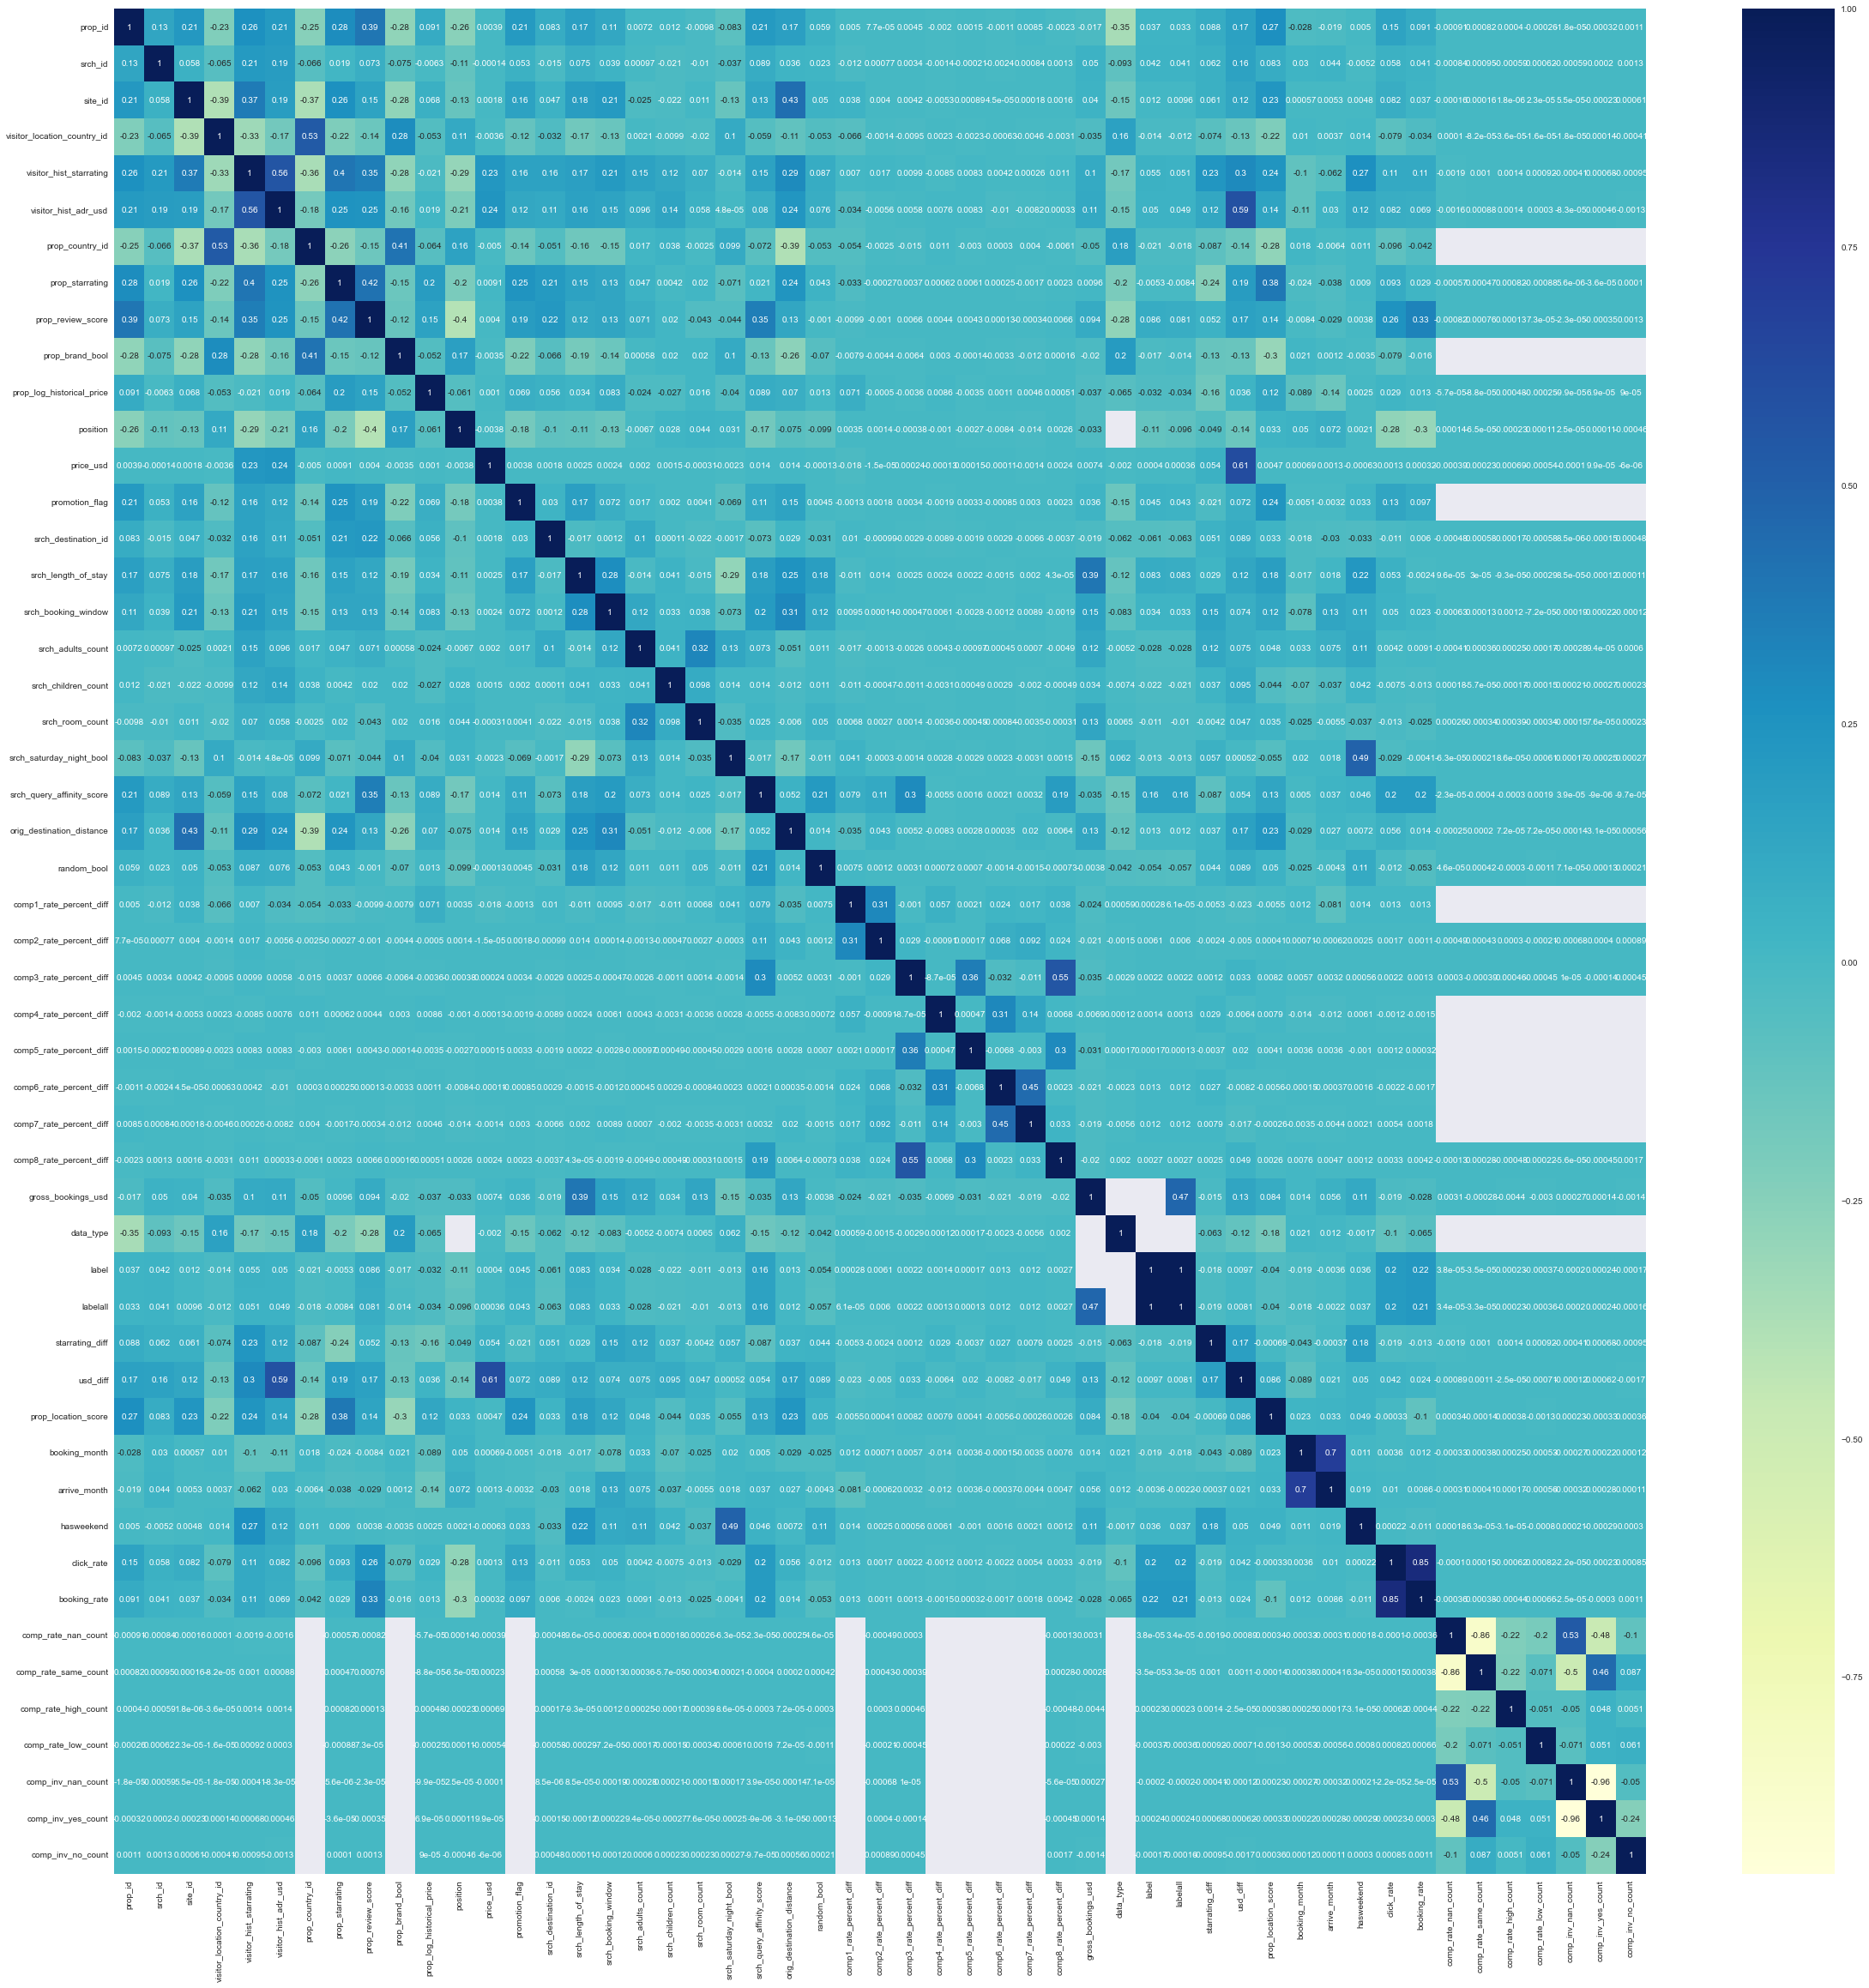

In [46]:
# 绘制相关性
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(newdata.corr(), annot=True, cmap="YlGnBu")

##### 主成分分析法特征方差贡献率绘图

### 6.模型训练

#### 6.1. 直接读取保存的特征数据文件

In [7]:
filename='hotelfeatdataset.csv'
t0 = datetime.datetime.now()
print("开始读取特征文件{}...".format(filename))
newdata=readcsvfile(filename)
print('读取特征文件一共用时{}秒'.format(datetime.datetime.now() - t0))
t0 = datetime.datetime.now()
newdata.set_index(newdata.columns[0],inplace=True)
print("开始优化内存...")
newdata=reduce_dataset_memory(newdata)
print('优化内存一共用时{}秒'.format(datetime.datetime.now() - t0))

开始读取特征文件hotelfeatdataset.csv...
读取特征文件一共用时0:00:51.133952秒
开始优化内存...
Memory usage of dataframe is 3631.91 MB
Memory usage after optimization is: 1059.31 MB
Decreased by 70.8%
优化内存一共用时0:00:05.434158秒


#### 6.2. 设定feature和label信息
1.从这里设置label，如label='label'将设置label列作为标签列   
2.将不参与训练的列加入nofeats,来设置那些作为特征列

In [8]:
nofeats=['labelall','labelmd','label','data_type','click_bool','booking_bool','gross_bookings_usd','position','click_bool','booking_bool']
label=['label']
group='srch_id'

number_feature=[]
category_feature=[]
for column in newdata.columns:
    if  str(newdata[column].dtype)[:5] == 'float':
        if column not in nofeats:
            number_feature.append(column)
    else:
        if column not in nofeats:
            category_feature.append(column)

print(number_feature)
print(category_feature)

['visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_review_score', 'prop_log_historical_price', 'price_usd', 'srch_query_affinity_score', 'orig_destination_distance', 'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff', 'starrating_diff', 'usd_diff', 'prop_location_score', 'click_rate', 'booking_rate']
['srch_id', 'site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_starrating', 'prop_brand_bool', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'random_bool', 'booking_month', 'arrive_month', 'hasweekend', 'comp_rate_nan_count', 'comp_rate_same_count', 'comp_rate_high_count', 'comp_rate_low_count', 'comp_inv_nan_count', 'comp_inv_yes_count', 'comp_inv_no_count']


#### 6.3. 样本划分训练集和校验集
根据上面设定的label列和特征列划分训练集、校验集和测试集，每次运行6.2修改label列或特征列时，需重新划分
数据集中数据与查询srch_id有关，不能将相同srch_id查询划分到不同的训练集和校验集，因此需按组划分

In [11]:
from sklearn.model_selection import GroupShuffleSplit

# 模型需要输入按srch_id排序后的样本

train = newdata[(newdata['data_type'] == 1)]
test = newdata[(newdata['data_type'] == 0)]

# 测试一下仅用预定酒店和浏览酒店数据进行训练,本地训练效果好，kaggle训练效果一般
#train=train[(train['booking_bool']|train['click_bool'])==True]

train.sort_values(by=group)
test.sort_values(by=group)
# 按组划分训练集和校验集
gss = GroupShuffleSplit(test_size=0.2,n_splits=1,random_state = 100).split(train, groups=train[group])
X_train_inds, X_valid_inds = next(gss)

traindataset= train.iloc[X_train_inds]
X_train = traindataset.loc[:, ~traindataset.columns.isin(nofeats)]
y_train = traindataset.loc[:, traindataset.columns.isin(label)]


# 每个训练集srch_id下样本的数量
groups_train = traindataset.groupby(group).size().to_frame('size')['size'].to_numpy()

validdataset= train.iloc[X_valid_inds]
X_valid = validdataset.loc[:, ~validdataset.columns.isin(nofeats)]
y_valid = validdataset.loc[:, validdataset.columns.isin(label)]

# 每个校验集srch_id下样本的数量
groups_valid = validdataset.groupby(group).size().to_frame('size')['size'].to_numpy()

X_test = test.loc[:, ~test.columns.isin(nofeats)]
y_test = test.loc[:, test.columns.isin(label)]

groups_test = test.groupby(group).size().to_frame('size')['size'].to_numpy()

In [36]:
X_test

srch_id  site_id  visitor_location_country_id  \
Unnamed: 0                                                  
4958347           1       24                          216   
4958348           1       24                          216   
4958349           1       24                          216   
4958350           1       24                          216   
4958351           1       24                          216   
...             ...      ...                          ...   
9917525      332787       24                          216   
9917526      332787       24                          216   
9917527      332787       24                          216   
9917528      332787       24                          216   
9917529      332787       24                          216   

            visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  \
Unnamed: 0                                                                   
4958347                         NaN                   NaN              219   
4958348                         NaN                   NaN              219   
4958349                         NaN                   NaN              219   
4958350                         NaN                   NaN              219   
4958351                         NaN                   NaN              219   
...                             ...                   ...              ...   
9917525                         NaN                   NaN              117   
9917526                         NaN                   NaN              117   
9917527                         NaN                   NaN              117   
9917528                         NaN                   NaN              117   
9917529                         NaN                   NaN              117   

            prop_id  prop_starrating  prop_review_score  prop_brand_bool  ...  \
Unnamed: 0                                                                ...   
4958347        3180                3                4.5             True  ...   
4958348        5543                3                4.5             True  ...   
4958349       14142                2                3.5             True  ...   
4958350       22393                3                4.5             True  ...   
4958351       24194                3                4.5             True  ...   
...             ...              ...                ...              ...  ...   
9917525       32019                4                3.5            False  ...   
9917526       33959                4                3.0             True  ...   
9917527       35240                4                0.0            False  ...   
9917528       94437                4                0.0            False  ...   
9917529       99509                4                4.5             True  ...   

            hasweekend  comp_rate_nan_count  comp_rate_same_count  \
Unnamed: 0                                                          
4958347          False                    8                     0   
4958348          False                    7                     1   
4958349          False                    6                     1   
4958350          False                    6                     2   
4958351          False                    6                     2   
...                ...                  ...                   ...   
9917525          False                    4                     0   
9917526          False                    4                     3   
9917527          False                    4                     3   
9917528          False                    4                     0   
9917529          False                    4                     4   

            comp_rate_high_count  comp_rate_low_count  comp_inv_nan_count  \
Unnamed: 0                                                                  
4958347                        0                    0                   8   
4958348             

#### 6.4. 训练模型

##### 6.4.1. Lightgbm

##### 6.4.1.1 训练

In [10]:
import lightgbm as lgb
t0 = datetime.datetime.now()
print("开始训练...")
print('label:{}'.format(label))
train_data = lgb.Dataset(X_train, label=y_train, group=groups_train) #,categorical_feature=category_feature
valid_data = lgb.Dataset(X_valid, label=y_valid, group=groups_valid,reference=train_data)#
evals_result = {}
params = {
        'task': 'train',  # 执行的任务类型
        'boosting_type': 'gbrt',  # 基学习器
        'objective': 'lambdarank',  # 排序任务(目标函数)
        'metric': 'ndcg',  # 度量的指标(评估函数)
        #'max_position': 10,  # @NDCG 位置优化
        'metric_freq': 1,  # 每隔多少次输出一次度量结果
        'train_metric': True,  # 训练时就输出度量结果
        'ndcg_at': [10],
        'max_bin': 255,  # 一个整数，表示最大的桶的数量。默认值为 255。lightgbm 会根据它来自动压缩内存。如max_bin=255 时，则lightgbm 将使用uint8 来表示特征的每一个值。
        'num_iterations': 750,  # 迭代次数，即生成的树的棵数
        'learning_rate': 0.08,  # 学习率
        'num_leaves': 31,  # 叶子数
         'max_depth':5,
        'tree_learner': 'serial',  # 用于并行学习，‘serial’： 单台机器的tree learner
        'min_data_in_leaf': 30,  # 一个叶子节点上包含的最少样本数量
        'verbose': 2  # 显示训练时的信息
    }
# 这里valid_sets可同时加入train_data，val_data
gbm = lgb.train(params,train_data,num_boost_round=50,valid_sets=[train_data,valid_data],evals_result=evals_result) 
model_save_path='htelmodel.txt'
gbm.save_model(model_save_path)
print('训练一共用时{}秒'.format(datetime.datetime.now() - t0))

开始训练...
label:['label']


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.896902
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.448068
[LightGBM] [Debug] init for col-wise cost 0.176603 seconds, init for row-wise cost 0.600627 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 5706
[LightGBM] [Info] Number of data points in the train set: 3971116, number of used features: 46
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[1]	training's ndcg@10: 0.438821	valid_1's ndcg@10: 0.440928
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[2]	training's ndcg@10: 0.46545	valid_1's ndcg@10: 0.467635
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[3]	training's ndcg@10:

##### 6.4.1.2 预测

In [44]:
# Predictions
pred_test = gbm.predict(X_test)
result= X_test.loc[:,['srch_id','prop_id']]
result['predicted_ranking']=pred_test
result.sort_values(by=['srch_id','predicted_ranking'], ascending=False,inplace=True)
result.set_index('srch_id',inplace=True)
result.loc[:,['prop_id']].to_csv('hotelpred.csv')
result.loc[:,['prop_id','predicted_ranking']]

prop_id  predicted_ranking
srch_id                            
332787     33959           0.388233
332787     99509           0.341622
332787     94437          -0.055002
332787     22854          -3.087308
332787     29018          -3.087308
...          ...                ...
1         134992          -1.094853
1          72090          -1.159254
1          61632          -3.087308
1          89466          -3.087308
1         123675          -3.087308

[4959183 rows x 2 columns]

#### 6.4.1.3. 特征重要性

In [42]:
importances = gbm.feature_importance(importance_type='split')
feature_names = gbm.feature_name()
sum = 0
for value in importances:
    sum += value
name_impo = sorted(list(zip(feature_names, importances)), key=lambda x: x[1], reverse=True)
for name, impo in name_impo:
    print('{} : {} : {}'.format(name, impo, impo / sum))


click_rate : 315 : 0.21
price_usd : 289 : 0.19266666666666668
prop_log_historical_price : 208 : 0.13866666666666666
prop_location_score : 205 : 0.13666666666666666
booking_rate : 190 : 0.12666666666666668
random_bool : 91 : 0.06066666666666667
prop_review_score : 67 : 0.04466666666666667
promotion_flag : 63 : 0.042
prop_starrating : 22 : 0.014666666666666666
prop_id : 9 : 0.006
usd_diff : 9 : 0.006
prop_country_id : 8 : 0.005333333333333333
srch_booking_window : 6 : 0.004
comp8_rate_percent_diff : 6 : 0.004
prop_brand_bool : 5 : 0.0033333333333333335
orig_destination_distance : 2 : 0.0013333333333333333
comp5_rate_percent_diff : 2 : 0.0013333333333333333
srch_length_of_stay : 1 : 0.0006666666666666666
comp2_rate_percent_diff : 1 : 0.0006666666666666666
starrating_diff : 1 : 0.0006666666666666666
srch_id : 0 : 0.0
site_id : 0 : 0.0
visitor_location_country_id : 0 : 0.0
visitor_hist_starrating : 0 : 0.0
visitor_hist_adr_usd : 0 : 0.0
srch_destination_id : 0 : 0.0
srch_adults_count : 0 : 

##### 特征重要性绘图

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

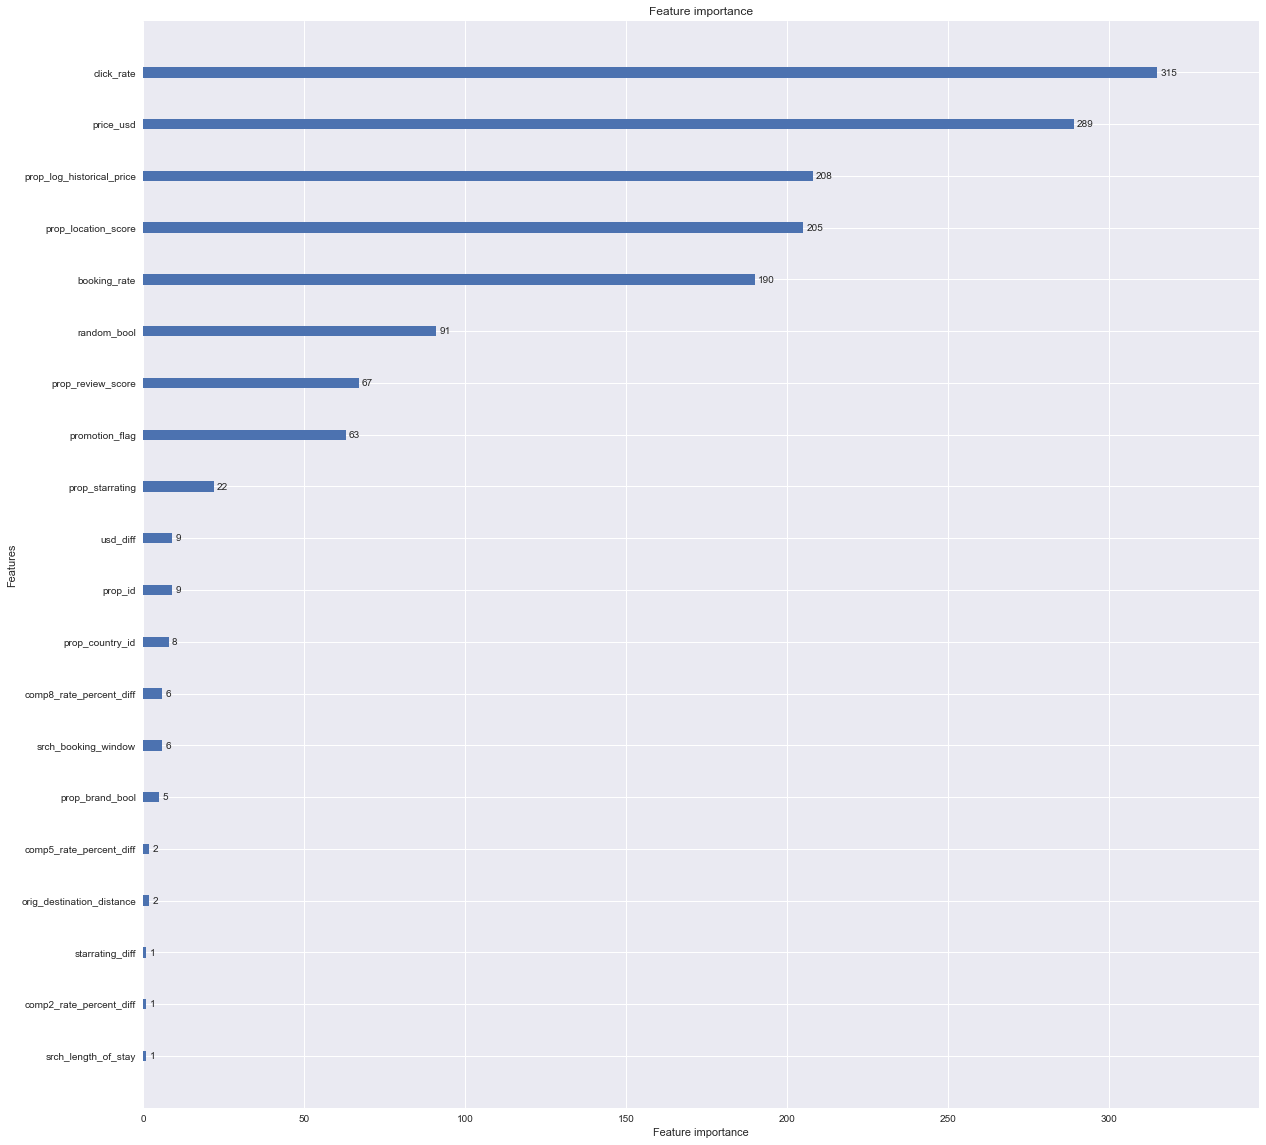

In [15]:
plt.style.use('seaborn')
lgb.plot_importance(gbm,figsize=(20, 20))

<AxesSubplot:title={'center':'Split value histogram for feature with name click_rate'}, xlabel='Feature split value', ylabel='Count'>

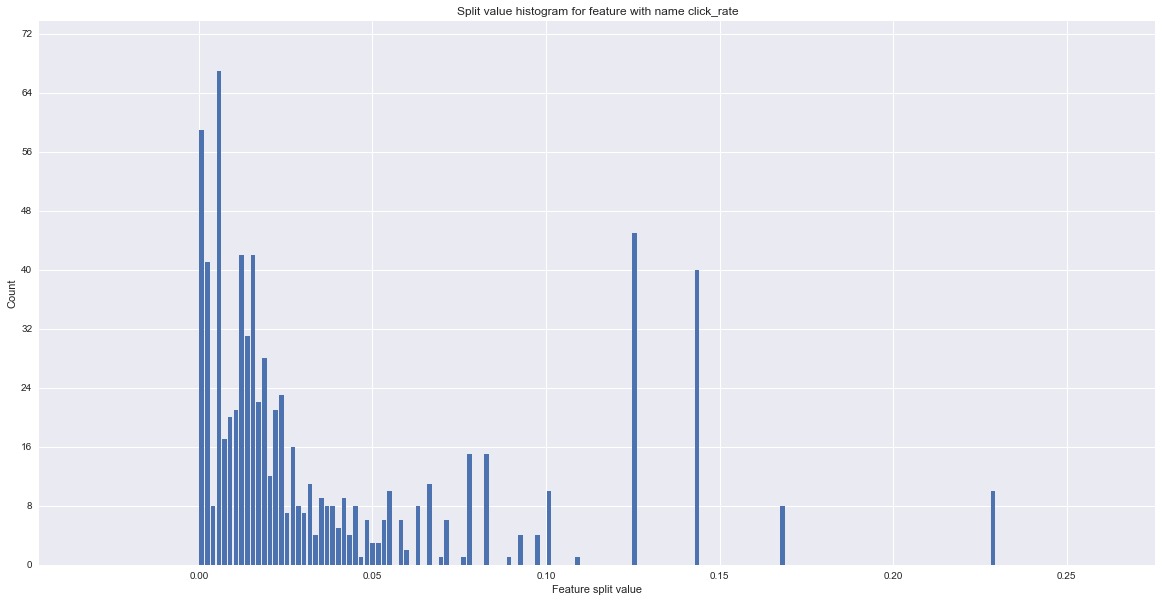

In [12]:
lgb.plot_split_value_histogram(gbm,feature='click_rate',figsize=(20, 10))

##### 6.4.1.4 树绘图分析

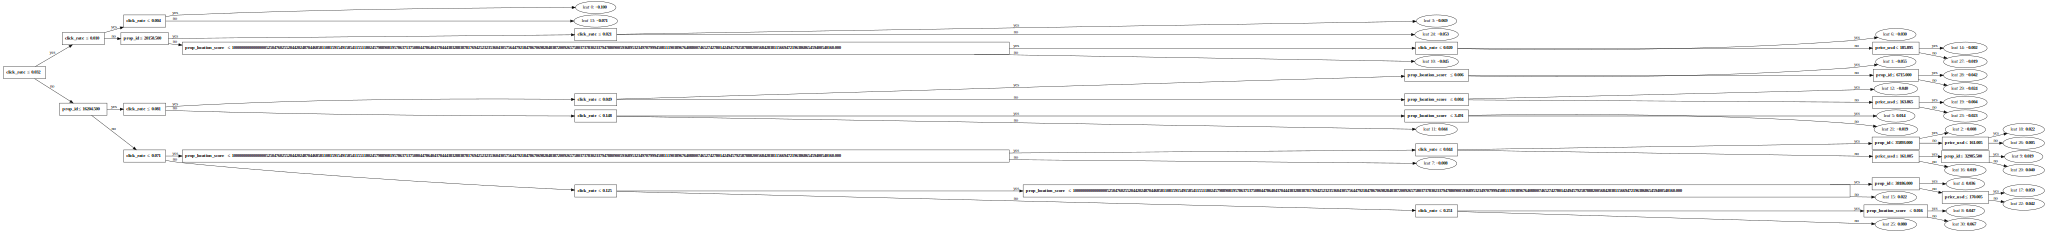

In [43]:
lgb.create_tree_digraph(gbm)

##### 6.4.2.XGBoost

##### 6.4.2.1 训练

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3971116 entries, 0 to 4958346
Data columns (total 23 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   srch_id                      int32  
 1   visitor_location_country_id  int16  
 2   prop_country_id              int16  
 3   prop_id                      int32  
 4   prop_starrating              int8   
 5   prop_review_score            float16
 6   prop_log_historical_price    float16
 7   price_usd                    float32
 8   promotion_flag               bool   
 9   srch_destination_id          int16  
 10  srch_length_of_stay          int8   
 11  srch_booking_window          int16  
 12  srch_query_affinity_score    float16
 13  orig_destination_distance    float16
 14  random_bool                  bool   
 15  comp2_rate_percent_diff      float32
 16  comp5_rate_percent_diff      float32
 17  comp8_rate_percent_diff      float32
 18  starrating_diff              float16
 19  

In [35]:
import xgboost as xgb
t0 = datetime.datetime.now()
print("开始训练...")
print('label:{}'.format(label))
params = {    
    'tree_method':'hist',
    'booster':'gbtree',
    'objective':'rank:ndcg',#'rank:map','rank:ndcg','rank:pairwise',
    'eval_metric':'ndcg',#'map','ndcg',
    'colsample_bytree':0.9, 
    'eta':0.05, #学习率
    'max_depth':6, 
    'subsample':0.75 
}

# xgboost原生接口调用方式
dtrain = xgb.DMatrix(X_train,y_train)
dtrain.set_group(groups_train)
dvalid = xgb.DMatrix(X_valid,y_valid)
dvalid.set_group(groups_valid)
dtest = xgb.DMatrix(X_test,y_test)
dtest.set_group(groups_test)
xgbmodel = xgb.train(params,dtrain=dtrain,evals=[(dtrain, 'train'),(dvalid, 'valid')],num_boost_round=50)
print('训练一共用时{}秒'.format(datetime.datetime.now() - t0))

开始训练...
label:['label']
[0]	train-ndcg:0.51389	valid-ndcg:0.51372
[1]	train-ndcg:0.51658	valid-ndcg:0.51645
[2]	train-ndcg:0.51655	valid-ndcg:0.51634
[3]	train-ndcg:0.51734	valid-ndcg:0.51740
[4]	train-ndcg:0.51841	valid-ndcg:0.51814
[5]	train-ndcg:0.51900	valid-ndcg:0.51846
[6]	train-ndcg:0.51970	valid-ndcg:0.51892
[7]	train-ndcg:0.52119	valid-ndcg:0.52066
[8]	train-ndcg:0.52055	valid-ndcg:0.52030
[9]	train-ndcg:0.52060	valid-ndcg:0.52032
[10]	train-ndcg:0.52083	valid-ndcg:0.52077
[11]	train-ndcg:0.52072	valid-ndcg:0.52053
[12]	train-ndcg:0.52088	valid-ndcg:0.52101
[13]	train-ndcg:0.52086	valid-ndcg:0.52077
[14]	train-ndcg:0.52107	valid-ndcg:0.52084
[15]	train-ndcg:0.52120	valid-ndcg:0.52081
[16]	train-ndcg:0.52128	valid-ndcg:0.52102
[17]	train-ndcg:0.52124	valid-ndcg:0.52063
[18]	train-ndcg:0.52127	valid-ndcg:0.52085
[19]	train-ndcg:0.52142	valid-ndcg:0.52100
[20]	train-ndcg:0.52158	valid-ndcg:0.52118
[21]	train-ndcg:0.52298	valid-ndcg:0.52267
[22]	train-ndcg:0.52300	valid-ndcg:0.522

In [91]:
xgbmodel.save_model ('xgbmodel.json')

##### 6.4.2.2预测

In [36]:
# Predictions
pred_test=xgbmodel.predict(dtest)
result= X_test.loc[:,['srch_id','prop_id']]
result['predicted_ranking']=pred_test
result.sort_values(by=['srch_id','predicted_ranking'], ascending=False,inplace=True)
result.set_index('srch_id',inplace=True)
result.loc[:,['prop_id']].to_csv('hotelpred.csv')
result.loc[:,['prop_id','predicted_ranking']]

prop_id  predicted_ranking
srch_id                            
332787     33959           1.247897
332787     99509           1.070458
332787     94437           1.066695
332787     32019          -1.135051
332787     22854          -1.136714
...          ...                ...
1          72090          -0.800493
1         134992          -0.894038
1         123675          -1.159590
1          61632          -1.169419
1          89466          -1.169419

[4959183 rows x 2 columns]

### 6.5 特征重要性分析

#### 6.5.1. 特征方差分析

In [59]:
newdata.var().sort_values(ascending=False)

srch_id                         9241202690.75555
prop_id                        1649316083.817222
price_usd                            205661808.0
srch_destination_id              65855371.266344
gross_bookings_usd                    674324.375
labelall                           430917.329913
usd_diff                            15646.003906
prop_country_id                      4671.405912
visitor_location_country_id          4344.069384
srch_booking_window                  2715.242554
position                              108.694285
site_id                                 58.63462
booking_month                          12.188114
arrive_month                           10.311311
comp_rate_nan_count                     7.008481
comp_rate_same_count                    6.166577
comp_inv_yes_count                      5.832701
comp_inv_nan_count                      5.603629
srch_length_of_stay                     4.271489
prop_starrating                         1.102902
comp_rate_high_count

#### 6.5.2 XGBoost 模型特征重要性
#### 平均增益gain

In [29]:
# feature importance
importance_type='gain'
features=pd.DataFrame.from_dict(xgbmodel.get_score(importance_type=importance_type), orient='index').rename(columns={0:importance_type})
gain=list(features[features[importance_type]>=features[importance_type].median()].index)
print(gain)
features.sort_values(by='gain',ascending=False)

['prop_country_id', 'prop_starrating', 'prop_review_score', 'prop_log_historical_price', 'price_usd', 'promotion_flag', 'srch_length_of_stay', 'random_bool', 'comp8_rate_percent_diff', 'prop_location_score', 'click_rate', 'booking_rate']


gain
click_rate                   4875.406738
booking_rate                 2077.529541
prop_location_score           570.081543
random_bool                   215.715057
price_usd                     150.383347
promotion_flag                128.122864
prop_log_historical_price      89.672424
prop_starrating                68.229500
prop_review_score              45.368164
comp8_rate_percent_diff        37.383881
prop_country_id                27.581455
srch_length_of_stay            19.524279
usd_diff                       18.093899
comp5_rate_percent_diff        15.471375
srch_booking_window            14.182959
prop_id                        13.374619
comp2_rate_percent_diff        12.199109
starrating_diff                 9.074780
orig_destination_distance       6.363727
srch_query_affinity_score       6.135536
srch_destination_id             5.786761
visitor_location_country_id     5.622534
srch_id                         5.431863

#### 权重weight

In [30]:
# feature importance
importance_type='weight'
features=pd.DataFrame.from_dict(xgbmodel.get_score(importance_type=importance_type), orient='index').rename(columns={0:importance_type})
weight=list(features[features[importance_type]>=features[importance_type].median()].index)
print(weight)
features.sort_values(by='weight',ascending=False)

['prop_country_id', 'prop_review_score', 'prop_log_historical_price', 'price_usd', 'promotion_flag', 'srch_length_of_stay', 'srch_booking_window', 'orig_destination_distance', 'random_bool', 'prop_location_score', 'click_rate', 'booking_rate']


weight
click_rate                    650.0
price_usd                     554.0
booking_rate                  384.0
random_bool                   351.0
prop_location_score           316.0
promotion_flag                229.0
prop_log_historical_price     145.0
prop_review_score              95.0
orig_destination_distance      48.0
prop_country_id                45.0
srch_booking_window            44.0
srch_length_of_stay            34.0
prop_starrating                32.0
srch_query_affinity_score      28.0
comp5_rate_percent_diff        28.0
comp8_rate_percent_diff        17.0
srch_destination_id            16.0
comp2_rate_percent_diff        16.0
usd_diff                       16.0
visitor_location_country_id    15.0
starrating_diff                15.0
prop_id                        12.0
srch_id                         8.0

#### 特征重要性绘图

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

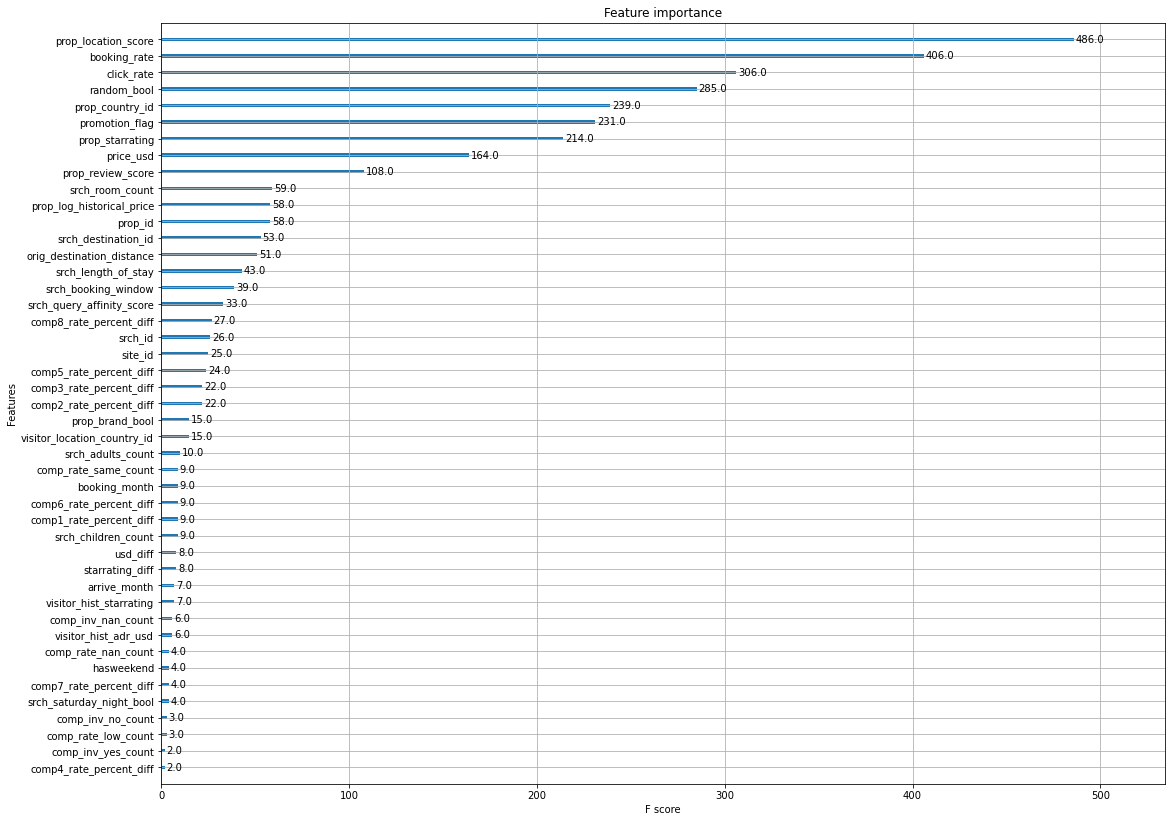

In [70]:
#plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (18.0, 14.0)
xgb.plot_importance(xgbmodel)

#### 6.5.3 可解释模型SHAP特征分析
调用shap库前将jupyter设为可信,否则有些图无法绘制   

In [105]:
#https://github.com/slundberg/shap
#SHAP（SHapley Additive exPlanations）是一种博弈论方法，用于解释任何机器学习模型的输出。它使用博弈论中的经典Shapley值及其相关扩展
#将最佳信用分配与局部解释联系起来（有关详细信息和引用，请参阅论文https://github.com/slundberg/shap#citations）。
import shap
explainer = shap.Explainer(xgbmodel)
shap_values = explainer(X_train)
#features=[ 'click_rate', 'booking_rate','prop_location_score','prop_starrating', 'prop_review_score', 'prop_brand_bool',
#    'prop_log_historical_price', 'price_usd', 'promotion_flag','srch_length_of_stay', 'random_bool','prop_country_id','srch_id', 'prop_id']

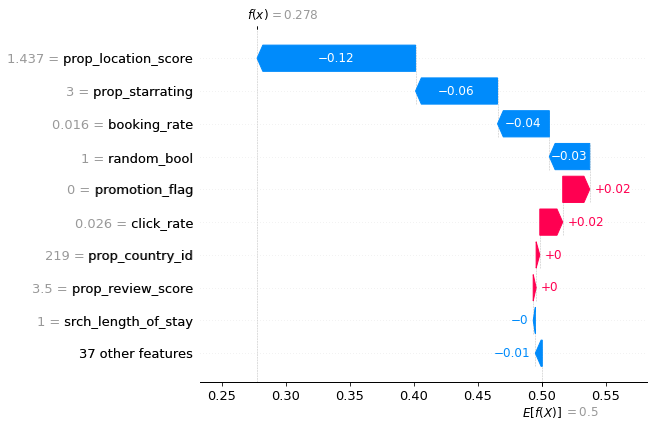

In [79]:
# visualize the first prediction's explanation
#上面的解释显示了每个功能都有助于将模型输出从基值（我们传递的训练数据集上的平均模型输出）推送到模型输出。
#推动预测较高的特征显示为红色，推动预测较高的特征显示为蓝色。
shap.plots.waterfall(shap_values[0])

In [ ]:
# visualize all the training set predictions
shap.plots.force(shap_values)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


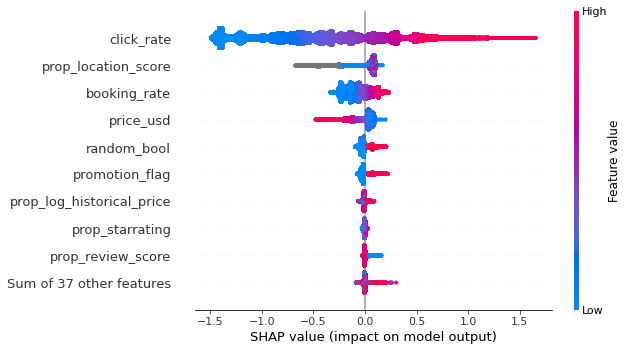

In [106]:
# summarize the effects of all the features
#为了大致了解哪些特征对模型最重要，我们可以为每个样本绘制每个特征的SHAP值。
#下图按所有样本的 SHAP 值大小之和对要素进行排序，并使用 SHAP 值显示每个要素对模型输出的影响分布。颜色表示要素值（红色高，蓝色低）。
shap.plots.beeswarm(shap_values)

#### 决策树图

<AxesSubplot:>

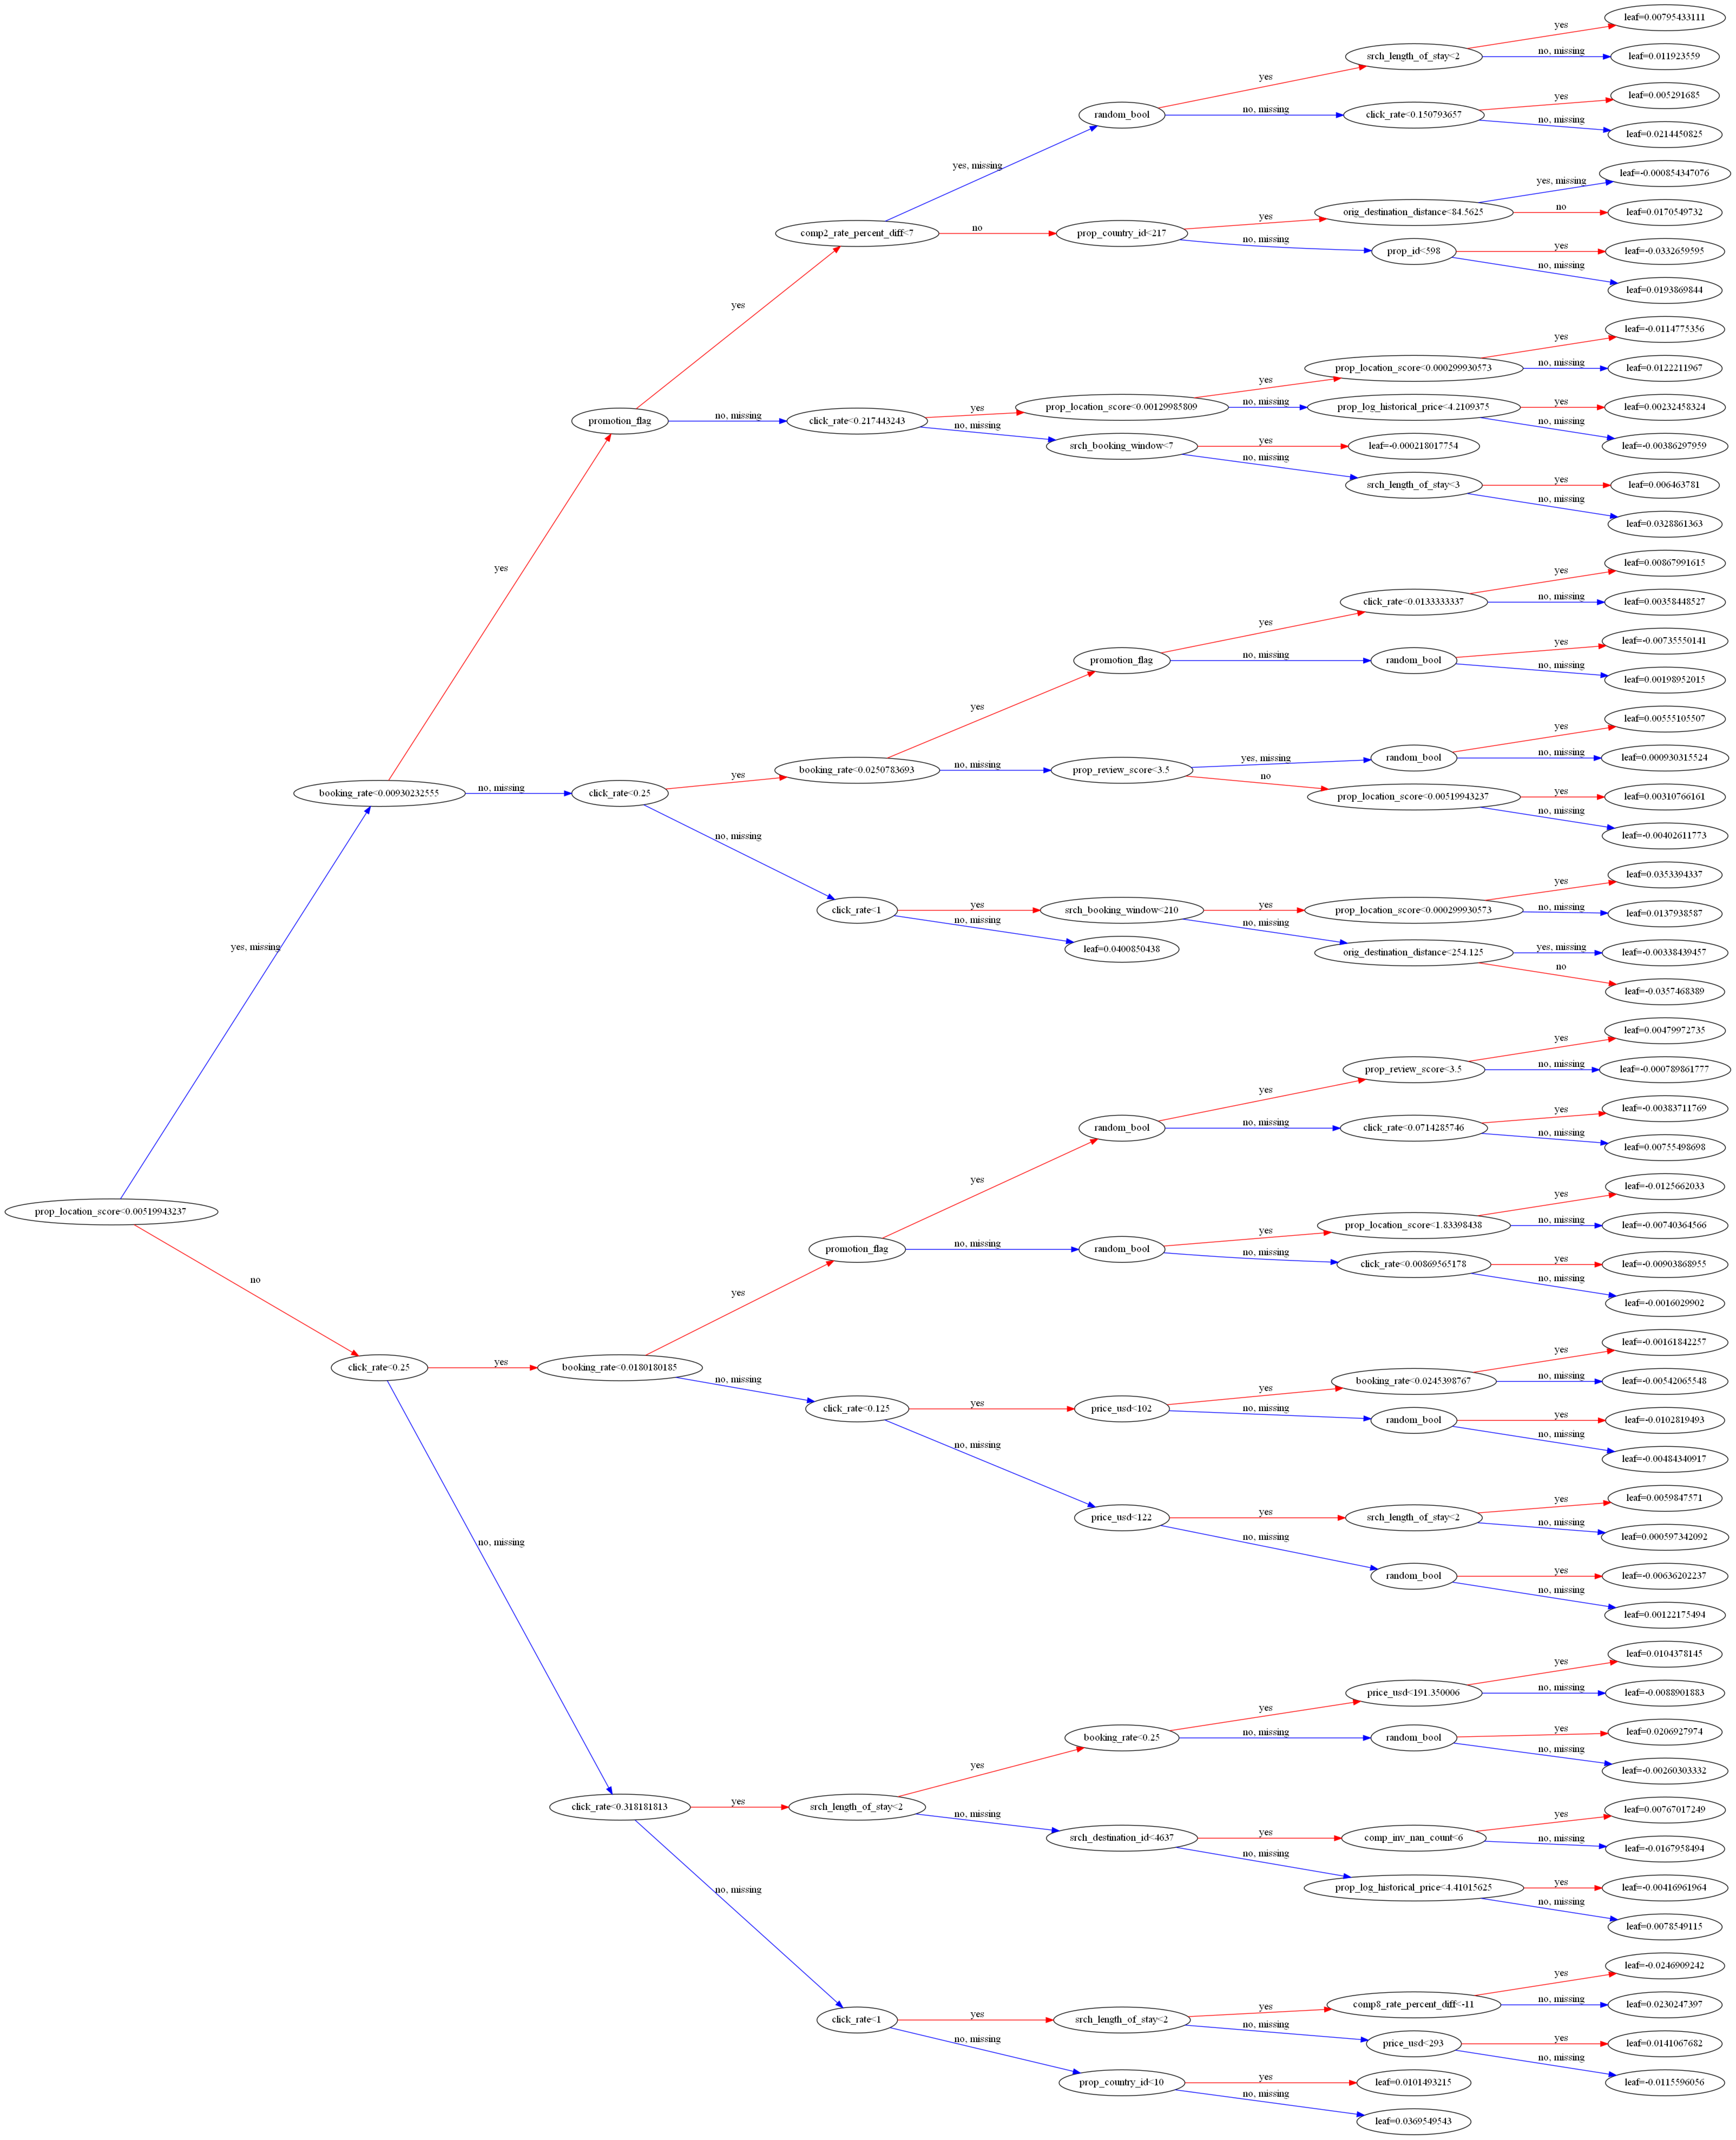

In [34]:
#plt.rcParams['figure.figsize'] = (200.0, 40.0)
fig,ax = plt.subplots()
fig.set_size_inches(100,300)
xgb.plot_tree(xgbmodel,ax = ax,num_trees=20, rankdir='LR')

#### 6.6 调参

In [20]:
# 内存不够时会出现XGBoostError: bad allocation

dtrain = xgb.DMatrix(X_train,y_train)
dtrain.set_group(groups_train)
params = {
    'tree_method':'hist',
    'booster':'gbtree',
    'objective':'rank:pairwise',
    'eval_metric':'ndcg',
    'colsample_bytree': 0.3,
    'eta': 0.05,
    'max_depth': 6, 
    'alpha': 10,
    'gamma':20}
num_round=50
n_fold=5
cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=n_fold,
                    num_boost_round=num_round,early_stopping_rounds=10,metrics="ndcg", as_pandas=True, seed=123)
cv_results

train-ndcg-mean  train-ndcg-std  test-ndcg-mean  test-ndcg-std
0          0.500472        0.000133        0.499974       0.000785
1          0.503621        0.000196        0.503234       0.001171
2          0.508501        0.000342        0.507907       0.001568
3          0.508009        0.000397        0.507339       0.001443
4          0.511724        0.000457        0.510902       0.001652
5          0.511310        0.000446        0.510161       0.001566
6          0.510856        0.000420        0.509918       0.001468
7          0.511089        0.000397        0.510090       0.001497
8          0.516719        0.000356        0.515350       0.001774
9          0.516365        0.000384        0.514893       0.001564
10         0.516293        0.000400        0.514706       0.001501
11         0.516526        0.000421        0.514975       0.001693
12         0.518202        0.000328        0.516524       0.001620
13         0.520235        0.000260        0.518522       0.001669
14         0.519791        0.000261        0.518064       0.001828
15         0.519425        0.000279        0.517649       0.001734
16         0.519066        0.000229        0.517438       0.001703
17         0.518831        0.000278        0.516926       0.001673
18         0.519449        0.000258        0.517597       0.001564
19         0.519144        0.000313        0.517274       0.001549
20         0.519797        0.000284        0.518039       0.001531
21         0.522124        0.000273        0.520229       0.001406
22         0.523930        0.000274        0.522240       0.001277
23         0.525940        0.000170        0.524162       0.001187

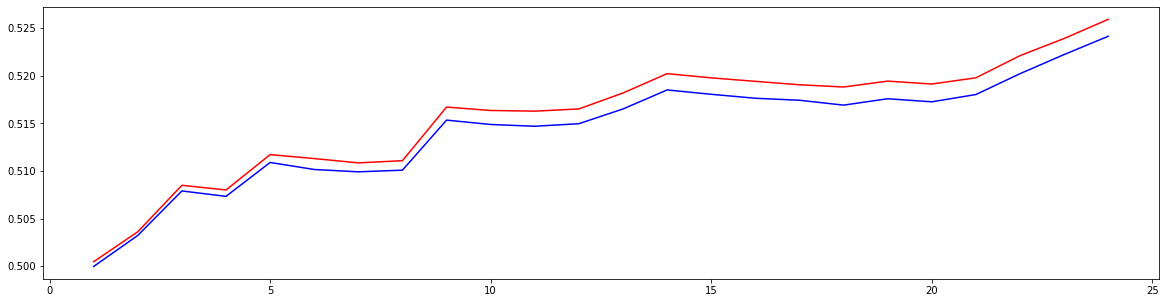

In [21]:
plt.figure(figsize=(20,5))
plt.plot(range(1,25),cv_results.iloc[:,0],color='red',label='train')
plt.plot(range(1,25),cv_results.iloc[:,2],color='blue',label='train')
plt.show()

In [67]:
import xgboost as xgb
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GroupKFold, RandomizedSearchCV

# 模型需要输入按srch_id排序后的样本
nofeats=['labelall','labelmd','label','data_type','click_bool','booking_bool','gross_bookings_usd','position','click_bool','booking_bool']
label=['label']
group='srch_id'

train = newdata[(newdata['data_type'] == 1)]
test = newdata[(newdata['data_type'] == 0)]

train.sort_values(by=group)
test.sort_values(by=group)

X_train = train.loc[:, ~train.columns.isin(nofeats)]
y_train = train.loc[:, train.columns.isin(label)]
# 每个训练集srch_id下样本的数量
q_train = train.groupby(group).size().to_frame('size')['size'].to_numpy()

parameters = {
    'max_depth': [4, 5,6,7, 8,9, 10],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
    'n_estimators': [400, 500, 600, 700, 800],#最佳迭代次数
    'min_child_weight': [0, 2, 5, 10, 20],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0.05, 0.1, 1, 2, 3], 
    'reg_lambda': [0.05, 0.1, 1, 2, 3],
}
gbm=xgb.XGBRanker(
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    eval_metric='ndcg',
    nthread=20,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=3,
    subsample=0.7,
    colsample_bytree=0.7,
    n_estimators=10)

gkf = GroupKFold(n_splits=5)

group_info = q_train.astype(int)
flatted_group = X_train[group]
gkf = GroupKFold(n_splits=5)
cv = gkf.split(X_train, y_train, groups=flatted_group)
cv_group = gkf.split(X_train, groups=flatted_group)  # separate CV generator for manual splitting groups

# generator produces `group` argument for LGBMRanker for each fold
def group_gen(flatted_group, cv):
    for train, _ in cv:
        yield np.unique(flatted_group[train], return_counts=True)[1]

gen = group_gen(flatted_group, cv_group)
grid = RandomizedSearchCV(gbm, params_grid, n_iter=10, cv=cv, verbose=2, scoring=ndcg_score, refit=False)
gbm=grid.fit(X_train, y_train, group=next(gen))

evalute_result = gbm.grid_scores_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gbm.best_params_))
print('最佳模型得分:{0}'.format(gbm.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[22:42:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass k=            label
Unnamed: 0       
147             0
148             0
149             0
150             0
151             0
...           ...
4958308         0
4958309         0
4958310         0
4958311         0
4958312         0

[991670 rows x 1 columns] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed.

[CV] END learning_rate=0.02, max_depth=20, n_estimators=10, num_leaves=100; total time= 1.1min
[22:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass k=            label
Unnamed: 0       
466             0
467             5
468             0
469             0
470             0
...           ...
4958284         0
4958285         0
4958286         0
4958287         0
4958288         0

[991670 rows x 1 columns] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed.

[CV] END learning_rate=0.02, max_depth=20, n_estimators=10, num_leaves=100; total time=  55.5s
[22:44:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END learning_rate=0.02, max_depth=20, n_estimators=10, num_leaves=100; total time=  16.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1842, in fit
    self._Booster = train(
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 1733, in update
    _check_call(_LIB.X

[22:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END learning_rate=0.02, max_depth=20, n_estimators=10, num_leaves=100; total time=  17.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1842, in fit
    self._Booster = train(
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 1733, in update
    _check_call(_LIB.X

[22:44:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END learning_rate=0.02, max_depth=20, n_estimators=10, num_leaves=100; total time=  17.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1842, in fit
    self._Booster = train(
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 1733, in update
    _check_call(_LIB.X

KeyboardInterrupt: 

### 7. 降维分析
降维制作了尝试，但没有使用

#### 7.1. 主成分分析法降维
本次实验测试使用了主成分分析法降维
目前训练速度较快，可不降维

In [37]:
##### import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

train = newdata[(newdata['data_type'] == 1)].replace(np.nan,0)

#test = newdata[(newdata['newdata_type'] == 0)]

train_x=train.loc[:,~train.columns.isin(nofeats)]
train_y=train.loc[:,train.columns.isin(label)]

# 标准化
standardscaler = StandardScaler()
train_x=standardscaler.fit_transform(train_x)

#参数n_components为主成分数量,mle为自动确定
pca=PCA(n_components='mle')
pca_result = pca.fit(train_x)
#主成分分析法，返回降维后的数据
pca.transform(train_x)
#每个特征方差贡献率
print(pca.explained_variance_ratio_)
#主成分数量
print(pca.n_components_)

[0.09428057 0.06736535 0.05160947 0.0431622  0.03662641 0.03617259
 0.03210727 0.03146427 0.03002485 0.02975669 0.02637452 0.02532269
 0.02351626 0.02231988 0.02187896 0.02180576 0.0217625  0.02173867
 0.02168399 0.02163692 0.02155672 0.02123812 0.0208822  0.01963866
 0.01887524 0.01863165 0.01809563 0.01761915 0.01695851 0.01627188
 0.0157981  0.01517637 0.01406329 0.01300473 0.0129406  0.0112451
 0.01079674 0.00947353 0.00727735 0.0071597  0.00680968 0.00326714
 0.00194392 0.00066617]
44


Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

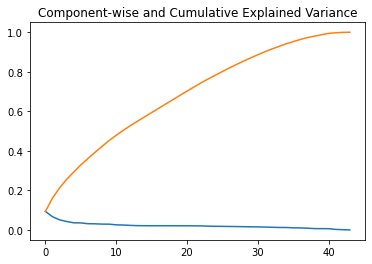

In [38]:
plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)
plt.plot(range(pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")